<a href="https://colab.research.google.com/github/Owenp25/Owen-Patrick-Soccer-Analytics-Portfolio/blob/main/Top_5_Football_Leagues_Clustering_Teams_by_Passing_Play_Style.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Top 5 Leagues: Clustering Teams by Passing Play Style**

For this project my goal is to cluster teams in the top 5 leagues by their passing statistics and pass types to determine teams that are similar in playing style. These statistics are scraped from FB Reference and they are all from the 2022-23 season. My initial plan is to do this with a combination of the aforementioned stats to best represent the team’s overall play style: this includes type of ball progression from defense to attack, amount of crosses, through balls, and short vs. long passes. I plan on using K-means clustering in python to do this. Often in the soccer world we classify teams on a scale somewhere between controlling possession and direct counter attack. I think this project is useful because it can show how these play styles can be quantified and how distinct the groups of tactical approaches are. If there are more distinct clusters, then it is evident that certain general patterns of play are effective across all of Europe’s best leagues. If there is more of a sliding scale of play styles, then we will have insight into how important individual managers’ philosophies are. Looking at contemporary literature, “K-means cluster analysis was also used by Gollan, Ferrar, and Norton [36] to recognize playing styles. Three game style clusters were identified: (1) moderately favoring established defense, (2) dominant in transition offense and transition defense, and (3) strong in established offense and set pieces. The disadvantage of this method is that it does neither recognize playing styles, nor is it capable of quantifying them; instead, it categorizes the teams based on the phases in which they excel” (Plakias S et al.,  Identifying Soccer Teams’ Styles of Play: A Scoping and Critical Review.) After reading this I still want to proceed with K-means clustering, but I will keep in mind the known downsides. It makes sense that clustering would result in teams being categorized based on what they are good at, so I will try and use statistics that are more representative of style of play instead of quality of play. For example, number of attempted/completed long and short passes rather than percent completed would be better at showing style of play.

References

Plakias S, Moustakidis S, Kokkotis C, Tsatalas T, Papalexi M, Plakias D, Giakas G, Tsaopoulos D. Identifying Soccer Teams’ Styles of Play: A Scoping and Critical Review. Journal of Functional Morphology and Kinesiology. 2023; 8(2):39. https://doi.org/10.3390/jfmk8020039



# **Scraping Data**

In [1]:
# My first step is scraping data from FBref using code courtesy of this article by Paul Corcoran: https://levelup.gitconnected.com/quickly-and-easily-scrape-fbref-using-just-pandas-773b294f86a0

In [2]:
# import statements
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# read in passing data for top5 leagues
top5_passing = pd.read_html('https://fbref.com/en/comps/Big5/2022-2023/passing/squads/2022-2023-Big-5-European-Leagues-Stats')

# read in passing type data for top 5 leagues
top5_passtypes = pd.read_html('https://fbref.com/en/comps/Big5/2022-2023/passing_types/squads/2022-2023-Big-5-European-Leagues-Stats')


In [3]:
# clean up formatting of each table's df, then save as dataframe
%%capture output

for idx,table in enumerate(top5_passing):
 print('***************************')
 print(idx)
 print(table)
t5_passing = top5_passing[0]

for idx,table in enumerate(top5_passtypes):
 print('***************************')
 print(idx)
 print(table)
t5_passtypes = top5_passtypes[0]


# **Cleaning and Formatting the Data**

Slice passing data set and do EDA from overall data set

In [4]:
t5_passing.columns

MultiIndex([( 'Unnamed: 0_level_0',      'Rk'),
            ( 'Unnamed: 1_level_0',   'Squad'),
            ( 'Unnamed: 2_level_0',    'Comp'),
            ( 'Unnamed: 3_level_0',    '# Pl'),
            ( 'Unnamed: 4_level_0',     '90s'),
            (              'Total',     'Cmp'),
            (              'Total',     'Att'),
            (              'Total',    'Cmp%'),
            (              'Total', 'TotDist'),
            (              'Total', 'PrgDist'),
            (              'Short',     'Cmp'),
            (              'Short',     'Att'),
            (              'Short',    'Cmp%'),
            (             'Medium',     'Cmp'),
            (             'Medium',     'Att'),
            (             'Medium',    'Cmp%'),
            (               'Long',     'Cmp'),
            (               'Long',     'Att'),
            (               'Long',    'Cmp%'),
            ('Unnamed: 19_level_0',     'Ast'),
            ('Unnamed: 20_level_0',     

In [5]:
# correct format: must rename sub columns with type of passing and then get ridof overarching index
# multi index caused me problems so changing to single index dataframe

new_columns = {
    ('Unnamed: 0_level_0', 'Rk'): ('Unnamed: 0_level_0', 'Rank'),
    ('Unnamed: 1_level_0', 'Squad'): ('Unnamed: 1_level_0', 'Squad'),
    ('Unnamed: 2_level_0', 'Comp'): ('Unnamed: 2_level_0', 'Competition'),
    ('Unnamed: 3_level_0', '# Pl'): ('Unnamed: 3_level_0', 'Num Players'),
    ('Unnamed: 4_level_0', '90s'): ('Unnamed: 4_level_0', 'Games'),
    (              'Total',     'Cmp'): (              'Total',     'Cmp_total'),
    (              'Total',     'Att'): (              'Total',     'Att_total'),
    (              'Total',    'Cmp%'): (              'Total',    'Cmp%_total'),
    (              'Total', 'TotDist'): (              'Total', 'Tot_Dist'),
    (              'Total', 'PrgDist'): (              'Total', 'Prg_Dist'),
    (              'Short',     'Cmp'): (              'Short',     'Cmp_short'),
    (              'Short',     'Att'): (              'Short',     'Att_short'),
    (              'Short',    'Cmp%'): (              'Short',    'Cmp%_short'),
    (             'Medium',     'Cmp'): (             'Medium',     'Cmp_med'),
    (             'Medium',     'Att'): (             'Medium',     'Att_med'),
    (             'Medium',    'Cmp%'): (             'Medium',    'Cmp%_med'),
    (               'Long',     'Cmp'): (               'Long',     'Cmp_long'),
    (               'Long',     'Att'): (               'Long',     'Att_long'),
    (               'Long',    'Cmp%'): (               'Long',    'Cmp%_long'),
    ('Unnamed: 19_level_0',     'Ast'): ('Unnamed: 19_level_0',     'Assists'),
    ('Unnamed: 20_level_0',     'xAG'): ('Unnamed: 20_level_0',     'x_AG'),
    ('Unnamed: 21_level_0',      'xA'): ('Unnamed: 21_level_0',      'x_A'),
    ('Unnamed: 22_level_0',   'A-xAG'): ('Unnamed: 22_level_0',   'A-x_AG'),
    ('Unnamed: 23_level_0',      'KP'): ('Unnamed: 23_level_0',      'K_P'),
    ('Unnamed: 24_level_0',     '1/3'): ('Unnamed: 24_level_0',     'Final Third'),
    ('Unnamed: 25_level_0',     'PPA'): ('Unnamed: 25_level_0',     'PPa'),
    ('Unnamed: 26_level_0',   'CrsPA'): ('Unnamed: 26_level_0',   'Crs_PA'),
    ('Unnamed: 27_level_0',    'PrgP'): ('Unnamed: 27_level_0',    'Prg_P')
}


In [6]:
top5_passing = pd.DataFrame(t5_passing.values, columns=new_columns.values())

print(top5_passing.columns)

MultiIndex([( 'Unnamed: 0_level_0',        'Rank'),
            ( 'Unnamed: 1_level_0',       'Squad'),
            ( 'Unnamed: 2_level_0', 'Competition'),
            ( 'Unnamed: 3_level_0', 'Num Players'),
            ( 'Unnamed: 4_level_0',       'Games'),
            (              'Total',   'Cmp_total'),
            (              'Total',   'Att_total'),
            (              'Total',  'Cmp%_total'),
            (              'Total',    'Tot_Dist'),
            (              'Total',    'Prg_Dist'),
            (              'Short',   'Cmp_short'),
            (              'Short',   'Att_short'),
            (              'Short',  'Cmp%_short'),
            (             'Medium',     'Cmp_med'),
            (             'Medium',     'Att_med'),
            (             'Medium',    'Cmp%_med'),
            (               'Long',    'Cmp_long'),
            (               'Long',    'Att_long'),
            (               'Long',   'Cmp%_long'),
            

In [7]:
top5_passing = top5_passing.droplevel(0, axis = 1)
top5_passtypes = t5_passtypes.droplevel(0, axis = 1)

In [8]:
print(top5_passtypes.columns)

Index(['Rk', 'Squad', 'Comp', '# Pl', '90s', 'Att', 'Live', 'Dead', 'FK', 'TB',
       'Sw', 'Crs', 'TI', 'CK', 'In', 'Out', 'Str', 'Cmp', 'Off', 'Blocks'],
      dtype='object')


In [9]:
top5_pass = top5_passing.merge(top5_passtypes, on='Squad', suffixes=('', '_remove'))

In [10]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

top5_pass

top5_pass.drop(['Comp', '# Pl', '90s', 'Att', 'Rk'], axis=1, inplace = True)

In [11]:
top5_pass


,Rank,Squad,Competition,Num Players,Games,Cmp_total,Att_total,Cmp%_total,Tot_Dist,Prg_Dist,Cmp_short,Att_short,Cmp%_short,Cmp_med,Att_med,Cmp%_med,Cmp_long,Att_long,Cmp%_long,Assists,x_AG,x_A,A-x_AG,K_P,Final Third,PPa,Crs_PA,Prg_P,Live,Dead,FK,TB,Sw,Crs,TI,CK,In,Out,Str,Cmp,Off,Blocks
0,1,Ajaccio,fr Ligue 1,36,38.0,11216,15286,73.4,206467,81586,4741,5780,82.0,4578,5701,80.3,1448,2889,50.1,12,22.7,23.4,-10.7,234,954,188,71,1169,13368,1855,562,39,57,631,795,126,42,65,0,11216,63,349
1,2,Almería,es La Liga,29,38.0,12151,15855,76.6,225475,89276,5232,6003,87.2,5084,6022,84.4,1512,2911,51.9,33,32.5,28.1,0.5,316,846,218,81,1090,13865,1907,552,49,132,605,750,147,58,59,1,12151,83,308
2,3,Angers,fr Ligue 1,33,38.0,14103,17463,80.8,252709,88748,5934,6810,87.1,6249,7208,86.7,1435,2536,56.6,18,28.0,27.6,-10.0,276,1124,214,65,1393,15689,1727,483,40,92,584,705,164,98,42,0,14103,47,294
3,4,Arsenal,eng Premier League,26,38.0,18281,21969,83.2,310206,100635,8542,9478,90.1,7825,8821,88.7,1454,2548,57.1,64,53.8,46.8,10.2,443,1637,459,62,2049,20293,1620,516,86,97,674,615,223,154,8,3,18281,56,379
4,5,Aston Villa,eng Premier League,26,38.0,13782,17396,79.2,244084,87581,6109,6945,88.0,5981,6936,86.2,1345,2579,52.2,35,38.8,31.6,-3.8,318,964,268,80,1242,15544,1794,599,54,101,561,684,162,97,19,4,13782,58,325
5,6,Atalanta,it Serie A,27,38.0,15462,19507,79.3,267971,97492,7245,8234,88.0,6234,7350,84.8,1525,2778,54.9,42,42.7,40.8,-0.7,405,1184,385,89,1637,17537,1912,432,35,154,652,893,194,97,67,0,15462,58,359
6,7,Athletic Club,es La Liga,26,38.0,14440,18630,77.5,261620,96037,6451,7431,86.8,6030,7262,83.0,1634,2878,56.8,33,38.9,35.7,-5.9,413,1385,341,107,1816,16594,1940,502,44,191,918,835,257,66,123,1,14440,96,386
7,8,Atlético Madrid,es La Liga,27,38.0,16814,20488,82.1,277627,101839,8616,9432,91.3,6028,7038,85.6,1549,2765,56.0,51,48.5,40.0,2.5,418,1200,335,68,1571,18630,1779,490,83,193,625,702,183,97,46,0,16814,79,345
8,9,Augsburg,de Bundesliga,34,34.0,8422,12742,66.1,169408,75215,3104,4032,77.0,3844,5050,76.1,1253,2819,44.4,29,24.3,24.6,4.7,240,662,191,44,847,10915,1769,428,30,73,548,745,166,78,81,1,8422,58,332
9,10,Auxerre,fr Ligue 1,33,38.0,12386,15989,77.5,240572,90967,4837,5709,84.7,5262,6177,85.2,1838,3237,56.8,17,27.2,25.6,-10.2,301,1020,243,82,1284,14213,1728,491,31,210,617,712,135,56,57,0,12386,48,305


In [12]:
print(top5_pass.columns)

Index(['Rank', 'Squad', 'Competition', 'Num Players', 'Games', 'Cmp_total',
       'Att_total', 'Cmp%_total', 'Tot_Dist', 'Prg_Dist', 'Cmp_short',
       'Att_short', 'Cmp%_short', 'Cmp_med', 'Att_med', 'Cmp%_med', 'Cmp_long',
       'Att_long', 'Cmp%_long', 'Assists', 'x_AG', 'x_A', 'A-x_AG', 'K_P',
       'Final Third', 'PPa', 'Crs_PA', 'Prg_P', 'Live', 'Dead', 'FK', 'TB',
       'Sw', 'Crs', 'TI', 'CK', 'In', 'Out', 'Str', 'Cmp', 'Off', 'Blocks'],
      dtype='object')


In [13]:
# We need the data in a per 90 basis so that it is easy to see team's play styles on a game
# by game basis and because the bundesliga plays 4 fewer games than the other leagues.

top5_pass[['Cmp_total', 'Att_total', 'Tot_Dist', 'Prg_Dist', 'Cmp_short',
       'Att_short', 'Cmp_med', 'Att_med', 'Cmp_long',
       'Att_long','Assists', 'x_AG', 'x_A', 'A-x_AG', 'K_P',
       'Final Third', 'PPa', 'Crs_PA', 'Prg_P', 'Live', 'Dead', 'FK',
       'TB', 'Sw', 'Crs', 'TI', 'CK', 'In', 'Out', 'Str', 'Cmp', 'Off',
       'Blocks']] = top5_pass[['Cmp_total',
       'Att_total', 'Tot_Dist', 'Prg_Dist', 'Cmp_short',
       'Att_short', 'Cmp_med', 'Att_med', 'Cmp_long',
       'Att_long','Assists', 'x_AG', 'x_A', 'A-x_AG', 'K_P',
       'Final Third', 'PPa', 'Crs_PA', 'Prg_P', 'Live', 'Dead', 'FK',
       'TB', 'Sw', 'Crs', 'TI', 'CK', 'In', 'Out', 'Str', 'Cmp', 'Off',
       'Blocks']].div(top5_pass.Games, axis=0).round(2)

In [14]:
top5_pass

,Rank,Squad,Competition,Num Players,Games,Cmp_total,Att_total,Cmp%_total,Tot_Dist,Prg_Dist,Cmp_short,Att_short,Cmp%_short,Cmp_med,Att_med,Cmp%_med,Cmp_long,Att_long,Cmp%_long,Assists,x_AG,x_A,A-x_AG,K_P,Final Third,PPa,Crs_PA,Prg_P,Live,Dead,FK,TB,Sw,Crs,TI,CK,In,Out,Str,Cmp,Off,Blocks
0,1,Ajaccio,fr Ligue 1,36,38.0,295.157895,402.263158,73.4,5433.342105,2147.0,124.763158,152.105263,82.0,120.473684,150.026316,80.3,38.105263,76.026316,50.1,0.315789,0.597368,0.615789,-0.281579,6.157895,25.105263,4.947368,1.868421,30.763158,351.789474,48.815789,14.789474,1.026316,1.5,16.605263,20.921053,3.315789,1.105263,1.710526,0.0,295.157895,1.657895,9.184211
1,2,Almería,es La Liga,29,38.0,319.763158,417.236842,76.6,5933.552632,2349.368421,137.684211,157.973684,87.2,133.789474,158.473684,84.4,39.789474,76.605263,51.9,0.868421,0.855263,0.739474,0.013158,8.315789,22.263158,5.736842,2.131579,28.684211,364.868421,50.184211,14.526316,1.289474,3.473684,15.921053,19.736842,3.868421,1.526316,1.552632,0.026316,319.763158,2.184211,8.105263
2,3,Angers,fr Ligue 1,33,38.0,371.131579,459.552632,80.8,6650.236842,2335.473684,156.157895,179.210526,87.1,164.447368,189.684211,86.7,37.763158,66.736842,56.6,0.473684,0.736842,0.726316,-0.263158,7.263158,29.578947,5.631579,1.710526,36.657895,412.868421,45.447368,12.710526,1.052632,2.421053,15.368421,18.552632,4.315789,2.578947,1.105263,0.0,371.131579,1.236842,7.736842
3,4,Arsenal,eng Premier League,26,38.0,481.078947,578.131579,83.2,8163.315789,2648.289474,224.789474,249.421053,90.1,205.921053,232.131579,88.7,38.263158,67.052632,57.1,1.684211,1.415789,1.231579,0.268421,11.657895,43.078947,12.078947,1.631579,53.921053,534.026316,42.631579,13.578947,2.263158,2.552632,17.736842,16.184211,5.868421,4.052632,0.210526,0.078947,481.078947,1.473684,9.973684
4,5,Aston Villa,eng Premier League,26,38.0,362.684211,457.789474,79.2,6423.263158,2304.763158,160.763158,182.763158,88.0,157.394737,182.526316,86.2,35.394737,67.868421,52.2,0.921053,1.021053,0.831579,-0.1,8.368421,25.368421,7.052632,2.105263,32.684211,409.052632,47.210526,15.763158,1.421053,2.657895,14.763158,18.0,4.263158,2.552632,0.5,0.105263,362.684211,1.526316,8.552632
5,6,Atalanta,it Serie A,27,38.0,406.894737,513.342105,79.3,7051.868421,2565.578947,190.657895,216.684211,88.0,164.052632,193.421053,84.8,40.131579,73.105263,54.9,1.105263,1.123684,1.073684,-0.018421,10.657895,31.157895,10.131579,2.342105,43.078947,461.5,50.315789,11.368421,0.921053,4.052632,17.157895,23.5,5.105263,2.552632,1.763158,0.0,406.894737,1.526316,9.447368
6,7,Athletic Club,es La Liga,26,38.0,380.0,490.263158,77.5,6884.736842,2527.289474,169.763158,195.552632,86.8,158.684211,191.105263,83.0,43.0,75.736842,56.8,0.868421,1.023684,0.939474,-0.155263,10.868421,36.447368,8.973684,2.815789,47.789474,436.684211,51.052632,13.210526,1.157895,5.026316,24.157895,21.973684,6.763158,1.736842,3.236842,0.026316,380.0,2.526316,10.157895
7,8,Atlético Madrid,es La Liga,27,38.0,442.473684,539.157895,82.1,7305.973684,2679.973684,226.736842,248.210526,91.3,158.631579,185.210526,85.6,40.763158,72.763158,56.0,1.342105,1.276316,1.052632,0.065789,11.0,31.578947,8.815789,1.789474,41.342105,490.263158,46.815789,12.894737,2.184211,5.078947,16.447368,18.473684,4.815789,2.552632,1.210526,0.0,442.473684,2.078947,9.078947
8,9,Augsburg,de Bundesliga,34,34.0,247.705882,374.764706,66.1,4982.588235,2212.205882,91.294118,118.588235,77.0,113.058824,148.529412,76.1,36.852941,82.911765,44.4,0.852941,0.714706,0.723529,0.138235,7.058824,19.470588,5.617647,1.294118,24.911765,321.029412,52.029412,12.588235,0.882353,2.147059,16.117647,21.911765,4.882353,2.294118,2.382353,0.029412,247.705882,1.705882,9.764706
9,10,Auxerre,fr Ligue 1,33,38.0,325.947368,420.763158,77.5,6330.842105,2393.868421,127.289474,150.236842,84.7,138.473684,162.552632,85.2,48.368421,85.184211,56.8,0.447368,0.715789,0.673684,-0.268421,7.921053,26.842105,6.394737,2.157895,33.789474,374.026316,45.473684,12.921053,0.815789,5.526316,16.236842,18.736842,3.552632,1.473684,1.5,

In [15]:
# change all numeric columns to float data type instead of object
for column in top5_pass.columns:
    # Check if the column is currently of object data type
    if top5_pass[column].dtype == 'object':
        # Try to convert the column to numeric
        try:
            top5_pass[column] = pd.to_numeric(top5_pass[column])
        except ValueError:
            # If the column contains non-numeric values, keep it as object type
            pass


In [16]:
top5_pass.dtypes

Rank             int64
Squad           object
Competition     object
Num Players      int64
Games          float64
Cmp_total      float64
Att_total      float64
Cmp%_total     float64
Tot_Dist       float64
Prg_Dist       float64
Cmp_short      float64
Att_short      float64
Cmp%_short     float64
Cmp_med        float64
Att_med        float64
Cmp%_med       float64
Cmp_long       float64
Att_long       float64
Cmp%_long      float64
Assists        float64
x_AG           float64
x_A            float64
A-x_AG         float64
K_P            float64
Final Third    float64
PPa            float64
Crs_PA         float64
Prg_P          float64
Live           float64
Dead           float64
FK             float64
TB             float64
Sw             float64
Crs            float64
TI             float64
CK             float64
In             float64
Out            float64
Str            float64
Cmp            float64
Off            float64
Blocks         float64
dtype: object

# **Box Plots- Comparisons within each league**

For this initial data exploration, I want to get a sense of the types of passing that are popular within each league. To do this, I will create box plots looking at each passing type (short, medium, long, through balls, crosses into the penalty area) as well as percent of passes completed. I will look at the median amount of each within each league, which will represent the 50th percentile team. I'm choosing this instead of the mean because it is a relatively small sample size and due to the presence of outliers in the form of the very best teams.

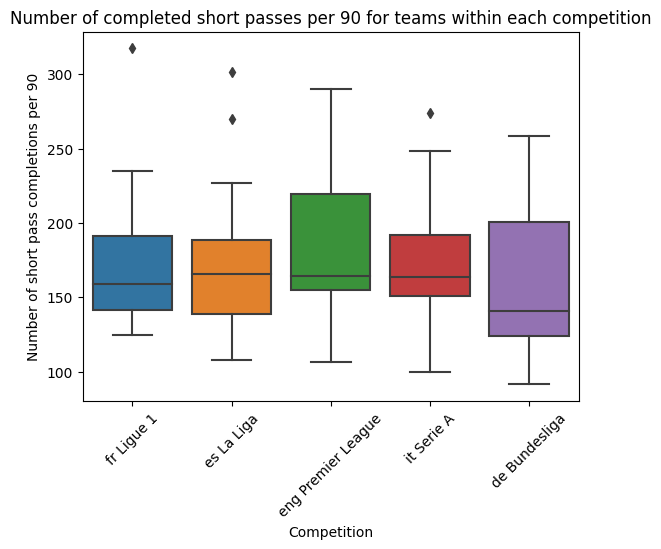

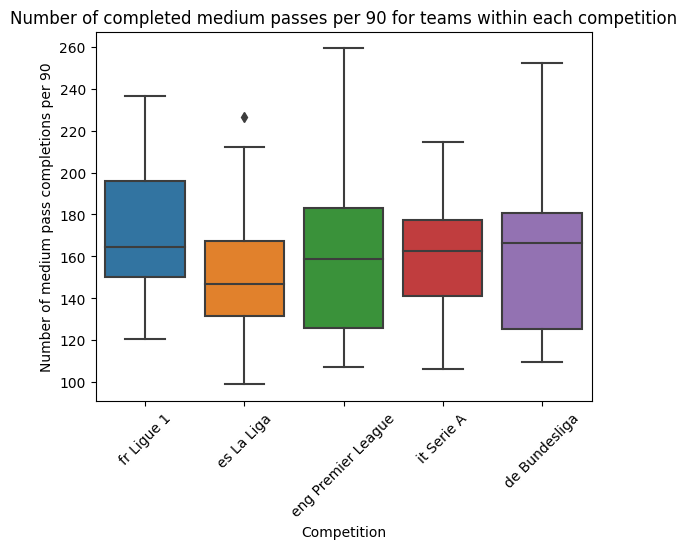

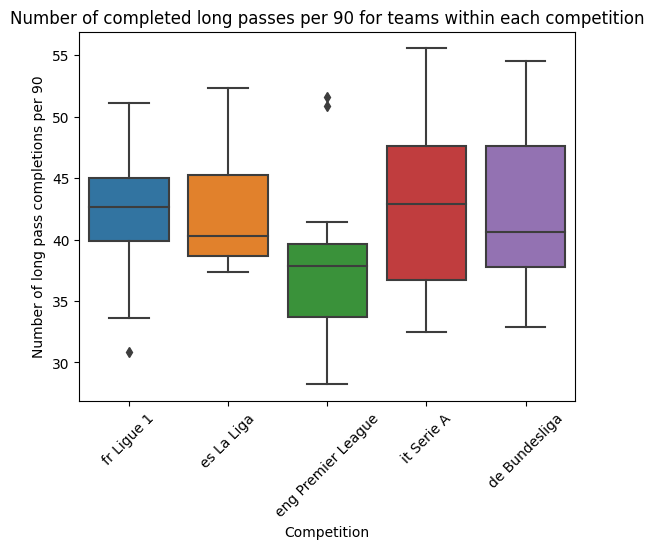

In [17]:
sns.boxplot(data=top5_pass, x='Competition', y='Cmp_short')

plt.title('Number of completed short passes per 90 for teams within each competition')
plt.xlabel('Competition')
plt.ylabel('Number of short pass completions per 90')

# Rotate the x-axis labels for better visibility
plt.xticks(rotation=45)

# Show the plot
plt.show()

sns.boxplot(data=top5_pass, x='Competition', y='Cmp_med')

plt.title('Number of completed medium passes per 90 for teams within each competition')
plt.xlabel('Competition')
plt.ylabel('Number of medium pass completions per 90')

# Rotate the x-axis labels for better visibility
plt.xticks(rotation=45)

# Show the plot
plt.show()


sns.boxplot(data=top5_pass, x='Competition', y='Cmp_long')

plt.title('Number of completed long passes per 90 for teams within each competition')
plt.xlabel('Competition')
plt.ylabel('Number of long pass completions per 90')

# Rotate the x-axis labels for better visibility
plt.xticks(rotation=45)

# Show the plot
plt.show()



Short passes: fewest in bundesliga, most in la liga and premier league

Medium passes: fewest in la liga, most in ligue 1 and bundesliga

long passes: By far the least in premier league and most in serie A and ligue 1

In terms of pass completions the prem is much more focused on short passing while it appears that ligue 1 is the most direct followed by the serie A.

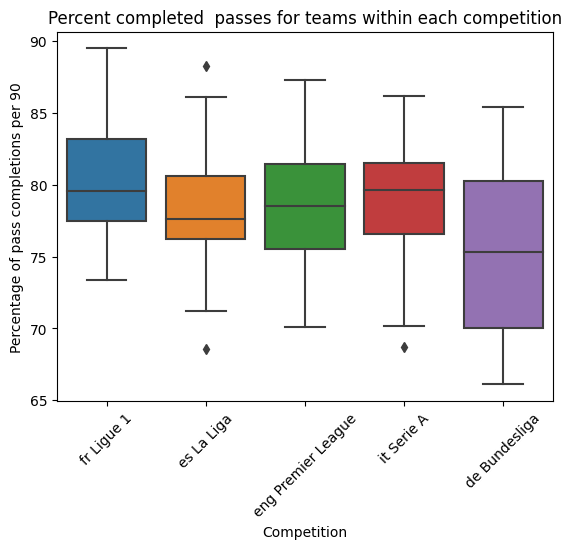

In [18]:
sns.boxplot(data=top5_pass, x='Competition', y='Cmp%_total')

plt.title('Percent completed  passes for teams within each competition')
plt.xlabel('Competition')
plt.ylabel('Percentage of pass completions per 90')

# Rotate the x-axis labels for better visibility
plt.xticks(rotation=45)

# Show the plot
plt.show()


Interestingly, ligue 1 and the Serie A have the highest median passes completed. I would have thought it would be the premier league given the quality of the players in the prem and the amount of short passes. The Bundesliga  has the lowest amount of completions which is surprising given the relatively low amount of long passes played.

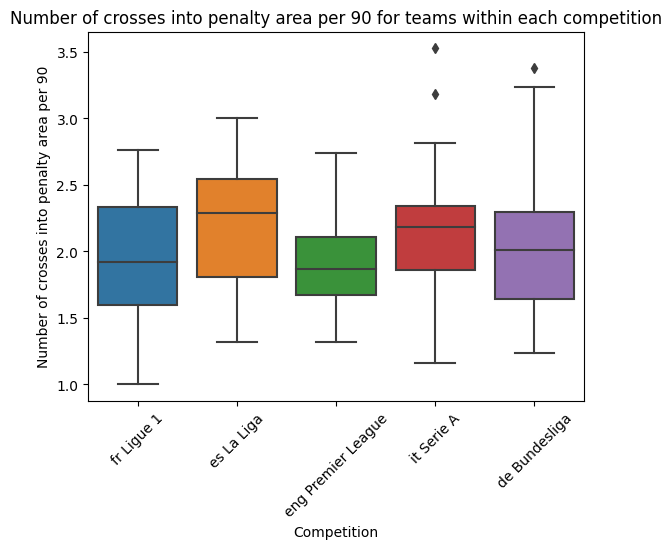

In [19]:
sns.boxplot(data=top5_pass, x='Competition', y='Crs_PA')

plt.title('Number of crosses into penalty area per 90 for teams within each competition')
plt.xlabel('Competition')
plt.ylabel('Number of crosses into penalty area per 90')

# Rotate the x-axis labels for better visibility
plt.xticks(rotation=45)

# Show the plot
plt.show()


La Liga is the most cross heavy league with the median at about 2.4 crosses into the penalty area per game while the premier league sits in last with around 1.8.

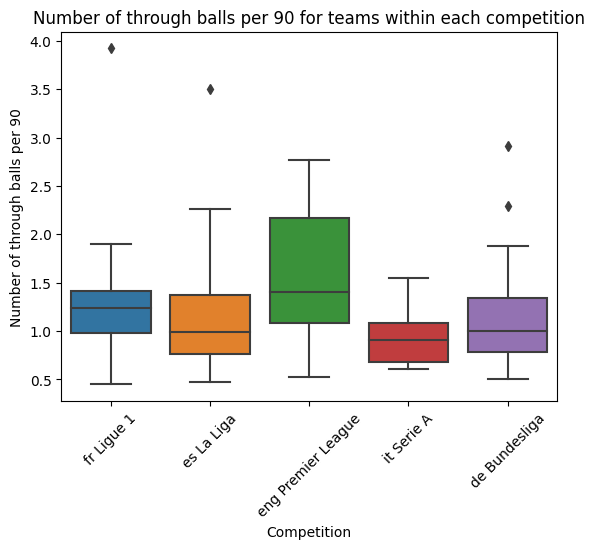

In [20]:
sns.boxplot(data=top5_pass, x='Competition', y='TB')

plt.title('Number of through balls per 90 for teams within each competition')
plt.xlabel('Competition')
plt.ylabel('Number of through balls per 90')

# Rotate the x-axis labels for better visibility
plt.xticks(rotation=45)

# Show the plot
plt.show()


We can see that the most through balls are played in the premier league when looking at the median for each competition. However, there are a couple outliers in every other league: these are the strongest teams in these competitions such as PSG, Barcelona, RB Leipzig, and Bayern.

# **Scatter Plots Based on Assists**

Now I want to look at what kind of passing style might be the most effective. I will create 4 scatter plots plotting short passing, crosses, through balls, and then long passes against assists to see if there is a strong positive linear relationship between any of these pairs. I want to see if any of these passing styles is connected to a higher output of assists.

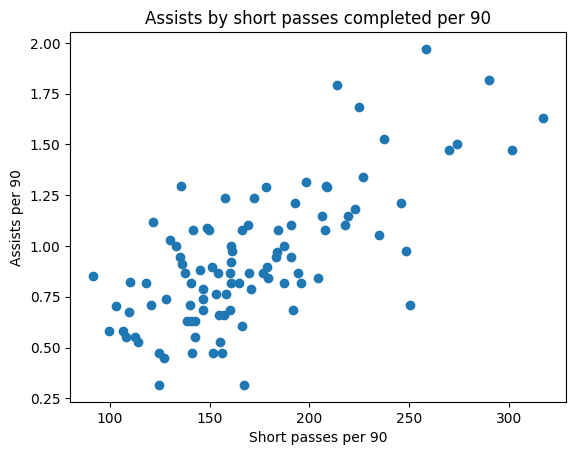

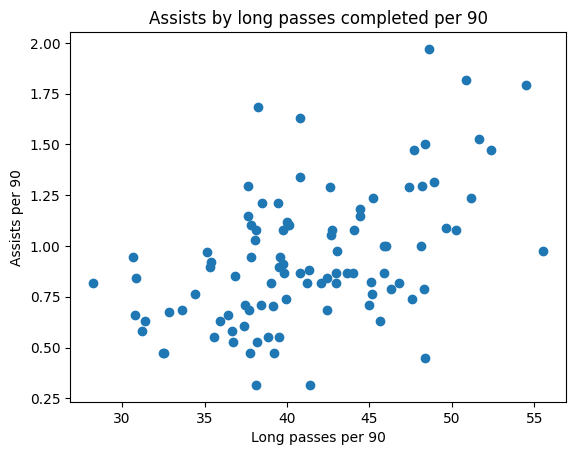

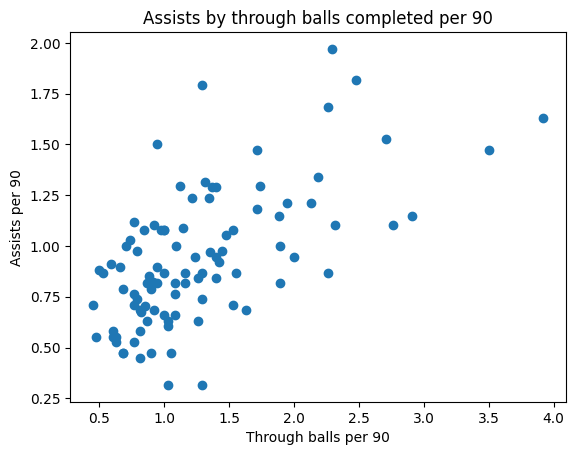

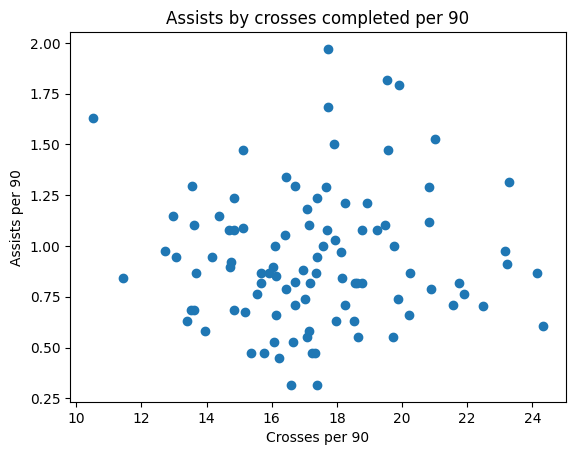

In [21]:
# short
plt.scatter(data = top5_pass, x = "Cmp_short", y = "Assists")
plt.title('Assists by short passes completed per 90')
plt.xlabel('Short passes per 90')
plt.ylabel('Assists per 90')
plt.show()

# long
plt.scatter(data = top5_pass, x = "Cmp_long", y = "Assists")
plt.title('Assists by long passes completed per 90')
plt.xlabel('Long passes per 90')
plt.ylabel('Assists per 90')
plt.show()

# through balls
plt.scatter(data = top5_pass, x = "TB", y = "Assists")
plt.title('Assists by through balls completed per 90')
plt.xlabel('Through balls per 90')
plt.ylabel('Assists per 90')
plt.show()

# crosses
plt.scatter(data = top5_pass, x = "Crs", y = "Assists")
plt.title('Assists by crosses completed per 90')
plt.xlabel('Crosses per 90')
plt.ylabel('Assists per 90')
plt.show()

In [22]:
print("Assists by short pass correlation:", np.corrcoef(top5_pass['Assists'], top5_pass['Cmp_short'])[0][1])
print("Assists by long pass correlation:", np.corrcoef(top5_pass['Assists'], top5_pass['Cmp_long'])[0][1])
print("Assists by through balls correlation:", np.corrcoef(top5_pass['Assists'], top5_pass['TB'])[0][1])
print("Assists by crosses correlation:", np.corrcoef(top5_pass['Assists'], top5_pass['Crs'])[0][1])

Assists by short pass correlation: 0.70619244267327
Assists by long pass correlation: 0.49891554790329207
Assists by through balls correlation: 0.6163375956235257
Assists by crosses correlation: 0.0332645937138646


In these scatterplots each point represents an individual team. Looking at the plot and the correlation coefficients, it is clear that a higher amount of completed short passes is most closely associated with a higher amount of assists. The correlation is fairly high at 0.706. It is interesting that a high number of assists is not very closely associated with a high amount of crosses as many teams rely on crosses as the main way of providing service to their strikers. This does not mean that increasing short passing equals more assists and increasing crossing is problematic, it merely backs up the fact that quality teams are able to complete more short passes and that crossing is a more unpredictable way of trying to fashion scoring chances.

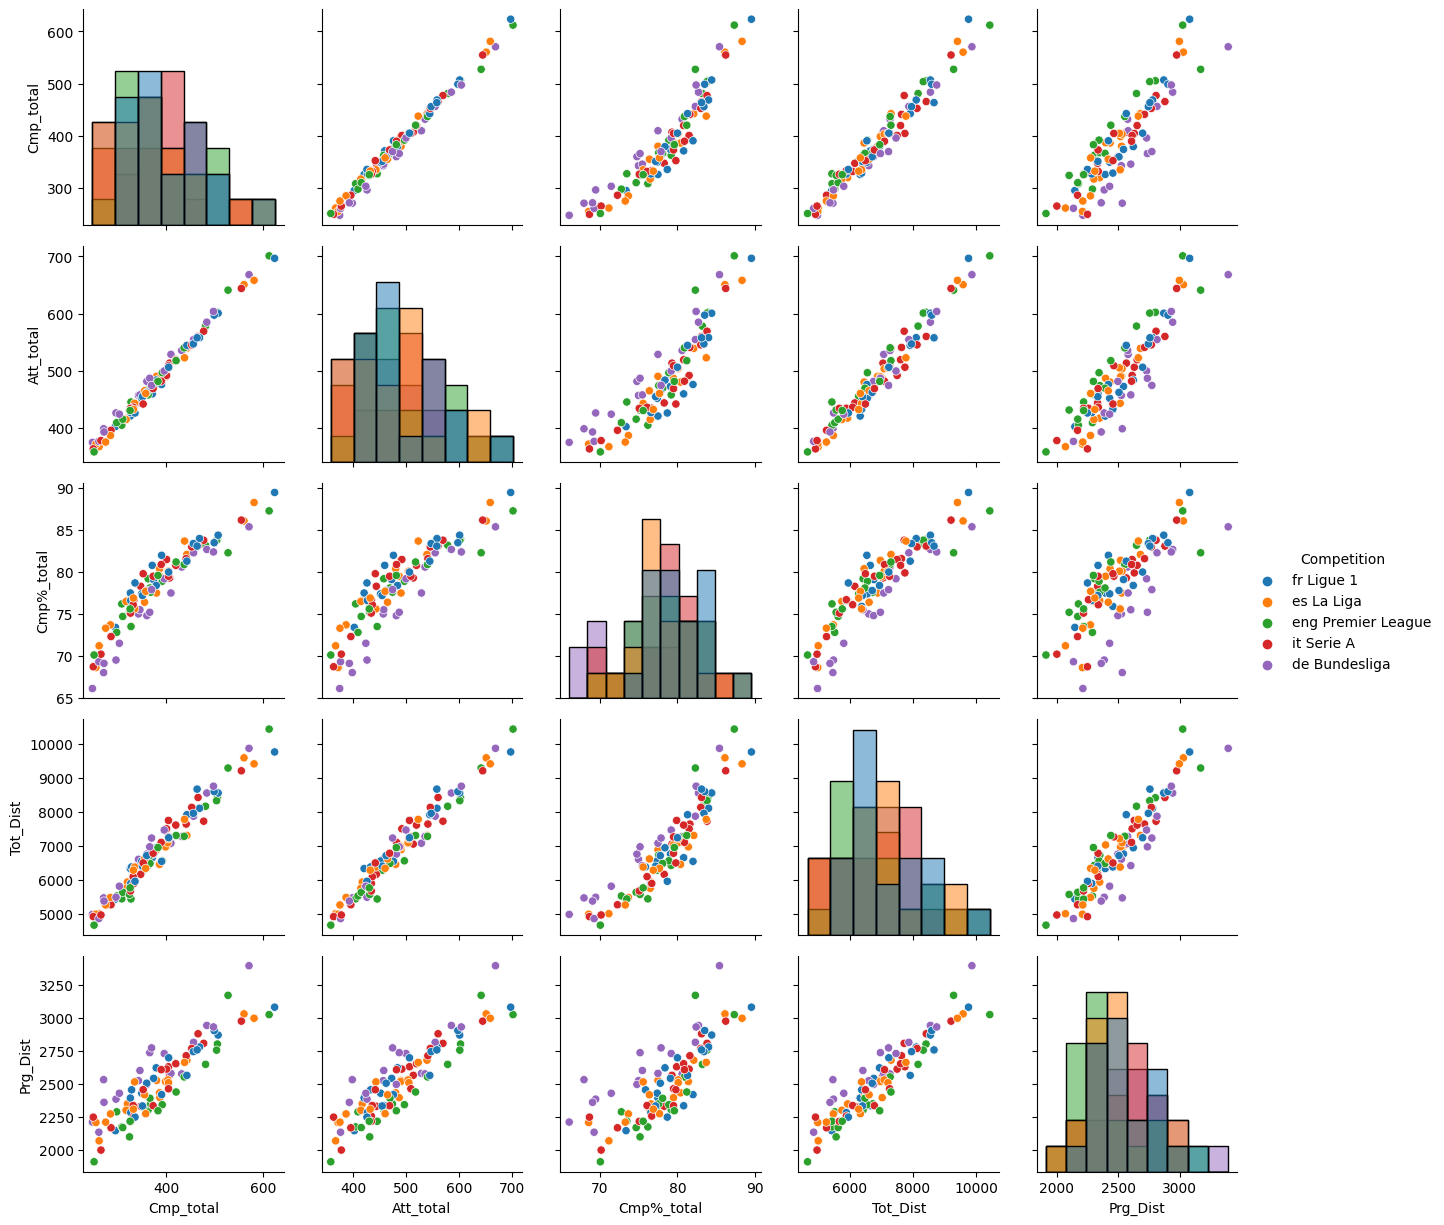

In [23]:
g = sns.PairGrid(top5_pass, vars= top5_pass.columns[5:10], hue="Competition")
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()

Looking at 5 of the passing variables, there appears to be a fairly strong positive correlation between most pairs of these. When looking at their distributions, their appears to be some skew present so I will definitely have to standardize the data before conducting PCA.

# **PCA and K Means Clustering**

Doing K Means clustering will split the data into groups centering around centroids specified by the algorithm. Due to the sheer number of features in the data, I will have to use PCA (Principal Component Analysis) to reduce the dimensions into fewer dimensions. This will take all of my numeric, correlated variables and reduce them into uncorrelated variables that contain as much of the information in the original data set as possible. I'm hoping to reduce the feature space down into 2 dimensions for visualization sake.

In [24]:
top5_pass.var().sort_values(ascending=False).head(10)

<ipython-input-24-88165cf54268>:1: FutureWarning: The default value of numeric_only in DataFrame.var is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  top5_pass.var().sort_values(ascending=False).head(10)


Tot_Dist     1.605516e+06
Prg_Dist     7.631889e+04
Cmp_total    7.142846e+03
Cmp          7.142846e+03
Live         6.379605e+03
Att_total    6.204551e+03
Att_short    2.163138e+03
Cmp_short    2.159594e+03
Cmp_med      1.275611e+03
Att_med      1.213692e+03
dtype: float64

Total distance and progressive distance have large variances compared to the other variables, this will be an issue with PCA because their large variances will dominate the principal components meaning that other variables' information will be lost out on. Because of this I will standardize the data. Also, I will drop all other columns that aren't necessary for analysis:

In [25]:
top5_pass.columns

Index(['Rank', 'Squad', 'Competition', 'Num Players', 'Games', 'Cmp_total',
       'Att_total', 'Cmp%_total', 'Tot_Dist', 'Prg_Dist', 'Cmp_short',
       'Att_short', 'Cmp%_short', 'Cmp_med', 'Att_med', 'Cmp%_med', 'Cmp_long',
       'Att_long', 'Cmp%_long', 'Assists', 'x_AG', 'x_A', 'A-x_AG', 'K_P',
       'Final Third', 'PPa', 'Crs_PA', 'Prg_P', 'Live', 'Dead', 'FK', 'TB',
       'Sw', 'Crs', 'TI', 'CK', 'In', 'Out', 'Str', 'Cmp', 'Off', 'Blocks'],
      dtype='object')

In [26]:
top5_pass_num = top5_pass.drop(columns = ['Rank', 'Squad', 'Competition', 'Num Players', 'Games'])
top5_pass_num

,Cmp_total,Att_total,Cmp%_total,Tot_Dist,Prg_Dist,Cmp_short,Att_short,Cmp%_short,Cmp_med,Att_med,Cmp%_med,Cmp_long,Att_long,Cmp%_long,Assists,x_AG,x_A,A-x_AG,K_P,Final Third,PPa,Crs_PA,Prg_P,Live,Dead,FK,TB,Sw,Crs,TI,CK,In,Out,Str,Cmp,Off,Blocks
0,295.157895,402.263158,73.4,5433.342105,2147.000000,124.763158,152.105263,82.0,120.473684,150.026316,80.3,38.105263,76.026316,50.1,0.315789,0.597368,0.615789,-0.281579,6.157895,25.105263,4.947368,1.868421,30.763158,351.789474,48.815789,14.789474,1.026316,1.500000,16.605263,20.921053,3.315789,1.105263,1.710526,0.000000,295.157895,1.657895,9.184211
1,319.763158,417.236842,76.6,5933.552632,2349.368421,137.684211,157.973684,87.2,133.789474,158.473684,84.4,39.789474,76.605263,51.9,0.868421,0.855263,0.739474,0.013158,8.315789,22.263158,5.736842,2.131579,28.684211,364.868421,50.184211,14.526316,1.289474,3.473684,15.921053,19.736842,3.868421,1.526316,1.552632,0.026316,319.763158,2.184211,8.105263
2,371.131579,459.552632,80.8,6650.236842,2335.473684,156.157895,179.210526,87.1,164.447368,189.684211,86.7,37.763158,66.736842,56.6,0.473684,0.736842,0.726316,-0.263158,7.263158,29.578947,5.631579,1.710526,36.657895,412.868421,45.447368,12.710526,1.052632,2.421053,15.368421,18.552632,4.315789,2.578947,1.105263,0.000000,371.131579,1.236842,7.736842
3,481.078947,578.131579,83.2,8163.315789,2648.289474,224.789474,249.421053,90.1,205.921053,232.131579,88.7,38.263158,67.052632,57.1,1.684211,1.415789,1.231579,0.268421,11.657895,43.078947,12.078947,1.631579,53.921053,534.026316,42.631579,13.578947,2.263158,2.552632,17.736842,16.184211,5.868421,4.052632,0.210526,0.078947,481.078947,1.473684,9.973684
4,362.684211,457.789474,79.2,6423.263158,2304.763158,160.763158,182.763158,88.0,157.394737,182.526316,86.2,35.394737,67.868421,52.2,0.921053,1.021053,0.831579,-0.100000,8.368421,25.368421,7.052632,2.105263,32.684211,409.052632,47.210526,15.763158,1.421053,2.657895,14.763158,18.000000,4.263158,2.552632,0.500000,0.105263,362.684211,1.526316,8.552632
5,406.894737,513.342105,79.3,7051.868421,2565.578947,190.657895,216.684211,88.0,164.052632,193.421053,84.8,40.131579,73.105263,54.9,1.105263,1.123684,1.073684,-0.018421,10.657895,31.157895,10.131579,2.342105,43.078947,461.500000,50.315789,11.368421,0.921053,4.052632,17.157895,23.500000,5.105263,2.552632,1.763158,0.000000,406.894737,1.526316,9.447368
6,380.000000,490.263158,77.5,6884.736842,2527.289474,169.763158,195.552632,86.8,158.684211,191.105263,83.0,43.000000,75.736842,56.8,0.868421,1.023684,0.939474,-0.155263,10.868421,36.447368,8.973684,2.815789,47.789474,436.684211,51.052632,13.210526,1.157895,5.026316,24.157895,21.973684,6.763158,1.736842,3.236842,0.026316,380.000000,2.526316,10.157895
7,442.473684,539.157895,82.1,7305.973684,2679.973684,226.736842,248.210526,91.3,158.631579,185.210526,85.6,40.763158,72.763158,56.0,1.342105,1.276316,1.052632,0.065789,11.000000,31.578947,8.815789,1.789474,41.342105,490.263158,46.815789,12.894737,2.184211,5.078947,16.447368,18.473684,4.815789,2.552632,1.210526,0.000000,442.473684,2.078947,9.078947
8,247.705882,374.764706,66.1,4982.588235,2212.205882,91.294118,118.588235,77.0,113.058824,148.529412,76.1,36.852941,82.911765,44.4,0.852941,0.714706,0.723529,0.138235,7.058824,19.470588,5.617647,1.294118,24.911765,321.029412,52.029412,12.588235,0.882353,2.147059,16.117647,21.911765,4.882353,2.294118,2.382353,0.029412,247.705882,1.705882,9.764706
9,325.947368,420.763158,77.5,6330.842105,2393.868421,127.289474,150.236842,84.7,138.473684,162.552632,85.2,48.368421,85.184211,56.8,0.447368,0.715789,0.673684,-0.268421,7.921053,26.842105,6.394737,2.157895,33.789474,374.026316,45.473684,12.921053,0.815789,5.526316,16.236842,18.736842,3.552632,1.473684,1.500000,0.000000,325.947368,1.263158,8.026316


In [27]:
# Standardize the data
scaler = StandardScaler()
top5_pass_num_scaled = scaler.fit_transform(top5_pass_num)

In [28]:
top5_pass_num_scaled

array([[-1.07045762, -1.08443959, -1.04277364, ..., -1.07045762,
        -0.39750251, -0.08956829],
       [-0.77782716, -0.893366  , -0.37032081, ..., -0.77782716,
         1.01527442, -1.19291389],
       [-0.16690237, -0.35339002,  0.51227354, ..., -0.16690237,
        -1.52772406, -1.56966605],
       ...,
       [-0.70959888, -0.72479141, -0.58046232, ..., -0.70959888,
        -0.46814136,  1.01377732],
       [-0.18350839, -0.16415348, -0.09713684, ..., -0.18350839,
        -0.9002849 , -0.00725269],
       [-0.0257512 , -0.07433526,  0.26010373, ..., -0.0257512 ,
        -0.46814136,  0.07189692]])

In [29]:
# perform PCA

pca = PCA(n_components=4)

top5_pass_pca = pca.fit_transform(top5_pass_num_scaled)

In [30]:
# The amount of variance explained by each component
explained_variance = pca.explained_variance_ratio_
explained_variance

array([0.53274815, 0.11079552, 0.06650173, 0.04622489])

In [31]:
# Cumulative variance explained by the components
cumulative_variance = np.cumsum(explained_variance)
cumulative_variance

array([0.53274815, 0.64354368, 0.7100454 , 0.75627029])

In [32]:
# Access the principal components themselves
principal_components = pca.components_
principal_components

array([[ 0.22142863,  0.2211344 ,  0.2043624 ,  0.22094567,  0.20602822,
         0.21010636,  0.2109222 ,  0.17721159,  0.21523817,  0.21288512,
         0.19656191,  0.12748939, -0.0552616 ,  0.19824776,  0.18483156,
         0.2022408 ,  0.19211389,  0.06181921,  0.19671039,  0.20867041,
         0.1994209 , -0.01614016,  0.20746302,  0.221322  , -0.09320716,
        -0.01185436,  0.166948  ,  0.07864463,  0.00603384, -0.08435625,
         0.14463563,  0.04220779,  0.06351943,  0.01431342,  0.22142863,
         0.02996843,  0.05584068],
       [-0.04722807, -0.022743  , -0.10675687,  0.02020128,  0.08214272,
        -0.10572843, -0.10275236, -0.11304725, -0.00295093,  0.01846512,
        -0.09858085,  0.28752291,  0.39237922,  0.03141849,  0.05097901,
         0.03895893,  0.08312708,  0.04406621,  0.11828917,  0.0335772 ,
         0.09106863,  0.35917354,  0.06749372, -0.03166028,  0.23667047,
         0.01363634, -0.13891414,  0.2232135 ,  0.39655635,  0.29391974,
         0.19257

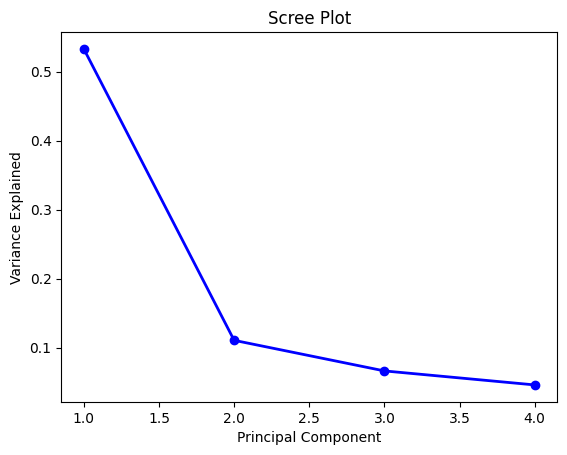

In [33]:
# scree plot

PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

Looking at the scree plot, 2 principal components seems to be the best choice as it is where the "elbow" in the plot is. The variance explained by the PC's drops off here showing that we have a pretty good portion of variance explained by just these two PC's, about 64.35%. Ideally this would be closer to 80 or 90 percent but I'll work with this for now.

In [34]:
# perform PCA

pca = PCA(n_components=2)

top5_pass_pca = pca.fit_transform(top5_pass_num_scaled)

Assuming there there will be three major groups of passing styles (quick short passing, mixed style, and direct long ball) I will choose 3 clusters for K means at first. If this doesn't perform well I will adjust as needed.

In [35]:
# perform Kmeans Clustering

from sklearn.cluster import KMeans

num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(top5_pass_pca)

# obtain cluster labels for each team
cluster_labels = kmeans.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


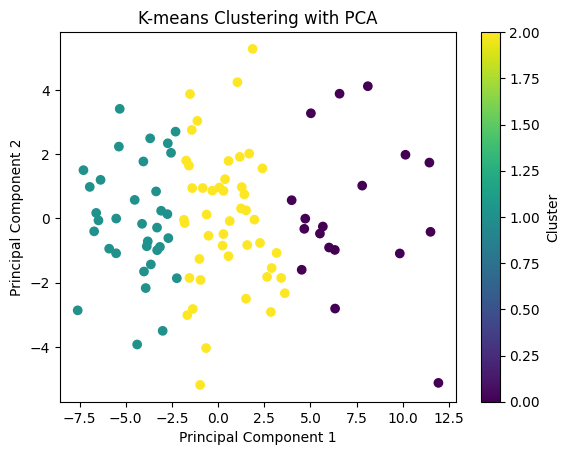

In [36]:
# visualize the clusters

plt.scatter(top5_pass_pca[:, 0], top5_pass_pca[:, 1], c=cluster_labels, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-means Clustering with PCA')
plt.colorbar(label='Cluster')
plt.show()

I'm not convinced about 3 clusters being the best, it could easily be 2 or 3, so I will use the elbow method and the within sums of squares in each cluster to determine the best number of clusters.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


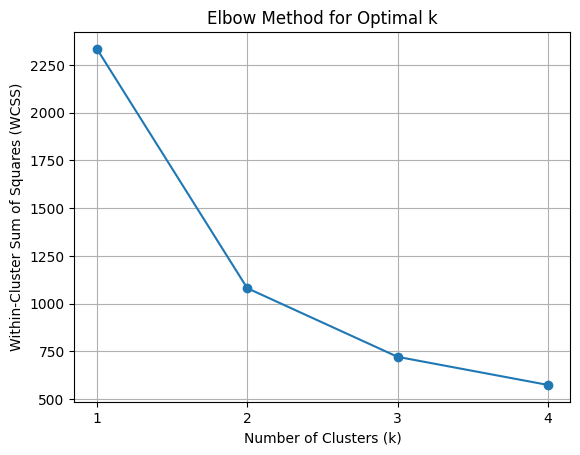

In [37]:
# within sums of squares list
wcss = []

# add wcss to the list for each amount of clusters
for k in range(1, 5):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(top5_pass_pca)
    wcss.append(kmeans.inertia_)

# Plot the WCSS for different values of k
plt.plot(range(1, 5), wcss, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Optimal k')
plt.xticks(range(1, 5))
plt.grid()
plt.show()

After looking at this plot, it looks like the WCSS starts to level off around 3 so it seems like this is the best choice for K after all. Now that I am confident in the number of clusters, It's time to see what exactly makes these teams similar.

In [38]:
pip install adjustText

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-39-90042ab4d754>:15: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(


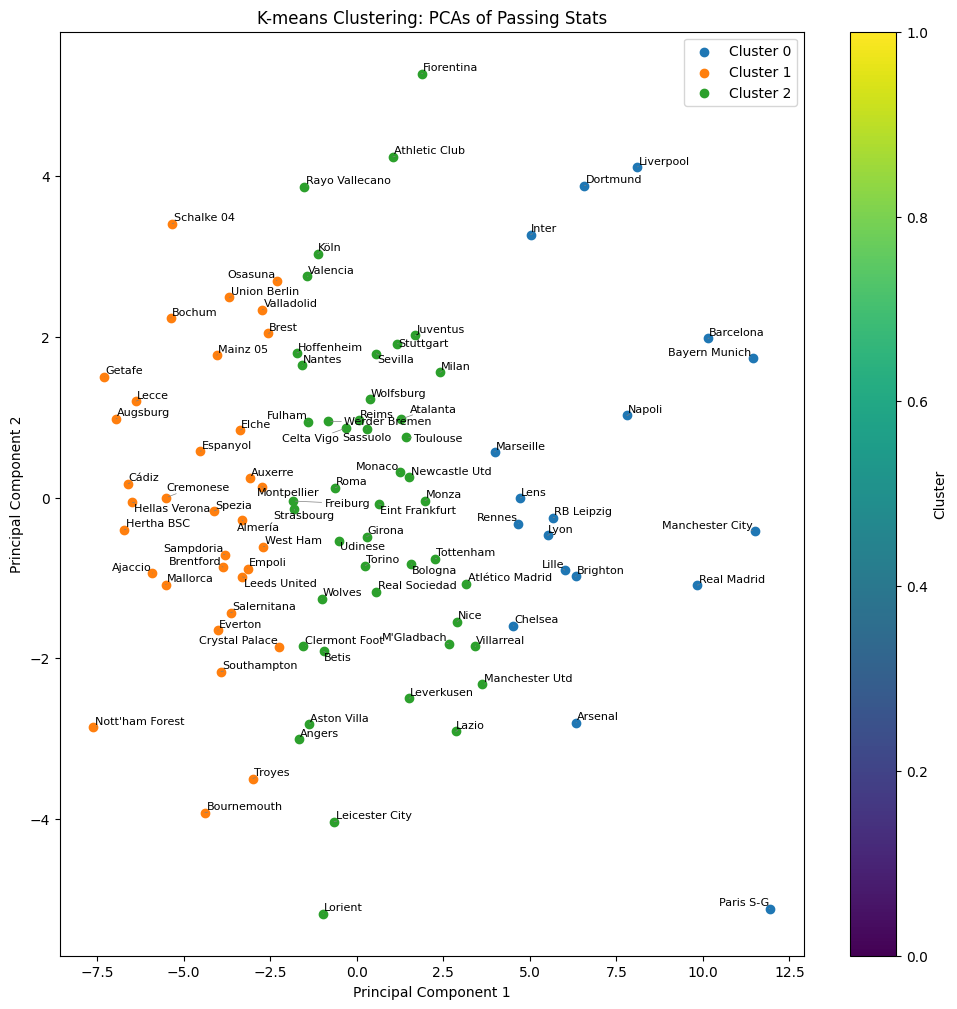

In [39]:
from adjustText import adjust_text

num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(top5_pass_pca)

# obtain cluster labels for each team
cluster_labels = kmeans.labels_

labels = top5_pass['Squad'].values

# Scatter plot the data points with different colors for each cluster and label points
plt.figure(figsize=(12,12))
for cluster_id in range(num_clusters):
    plt.scatter(
        top5_pass_pca[cluster_labels == cluster_id, 0],
        top5_pass_pca[cluster_labels == cluster_id, 1],
        label=f'Cluster {cluster_id}',
        cmap='viridis',
    )

texts = []
for i in range(len(top5_pass_pca)):
    texts.append(plt.text(top5_pass_pca[i, 0], top5_pass_pca[i, 1], labels[i], fontsize=8))

# Add labels from the original dataset
# for i in range(len(top5_pass_pca)):
#    plt.text(top5_pass_pca[i, 0], top5_pass_pca[i, 1], labels[i], fontsize=6)

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='grey', lw=0.5))

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-means Clustering: PCAs of Passing Stats')
plt.colorbar(label='Cluster')
plt.legend()
plt.show()

This plot is now labeled with each team's name and it shows the three clusters. Immediately, what jumps out to me is that the teams in cluster 0 are the best teams in their respective leagues for the most part. The top 4 ligue un teams, top 2 prem teams, top 2 la liga teams, top 3 bundesliga teams, and first and third place serie a teams are in this cluster. However, Brighton placed 6th and are in this cluster which is a bit lower in the table. The real surprise is Chelsea-- even though they performed so poorly this year (12th) they still are in the cluster with these top teams in terms of passing style.

In [40]:
loadings = pca.components_

# Identify the most important variables for each principal component
num_principal_components = 2

# Create a DataFrame to store the loadings and variable names
loadings_df = pd.DataFrame(loadings.T, columns=[f"PC{i+1}" for i in range(num_principal_components)], index=top5_pass_num.columns)

# Sort the variables by the absolute values of the loadings for each principal component
most_important_variables = {}
for i in range(num_principal_components):
    most_important_variables[f"PC{i+1}"] = loadings_df[f"PC{i+1}"].abs().nlargest(5).index.tolist()

# Display the most important variables for each principal component
for component, variables in most_important_variables.items():
    print(f"Principal Component {component}: {variables}")

Principal Component PC1: ['Cmp', 'Cmp_total', 'Live', 'Att_total', 'Tot_Dist']
Principal Component PC2: ['Crs', 'Att_long', 'Crs_PA', 'Out', 'TI']


Looking at the most important variables in PC1, it is clear that this is capturing variability of variables such as completed passes, total completed passes, live passes etc. These are not indicators of passing style, just of quality. The teams higher on the x axis are better (complete more passes and attacking passes) while the ones closer to 0 on the x axis are worse passing teams. This is supported by looking at the plot-- teams that finished very well are on the right while relegation teams are on the left. The y axis, however, is more interesting. The 2nd PC explains variability in Crosses, long passes and crosses into the penalty area. From this we can consider teams higher up on the y axis to be more direct, such as Fiorentina and athletic club. The clusters do not seem to represent style of passing, I think it may be useful to pair down the features included to ones that are vital for passing style instead of all of the passing variables. Total completed passing and total distance are not very useful when we already have the breakdown of short, medium, and long passes. On top of this, only 64.36% of the information in the data is captured by the first two PCs. In this next step I will try to improve this as well.

# **K-Means and PCA: pairing down features used**

To try and get more interpretable results, I will keep variables that I think are vital for understanding passing style. These are through balls, switches, Crosses, offsides passes, attempted short passes, medium passes, long passes, passes into final third, crosses into penalty area, and progressive passes.

In [41]:
top5_pass_num.columns

Index(['Cmp_total', 'Att_total', 'Cmp%_total', 'Tot_Dist', 'Prg_Dist',
       'Cmp_short', 'Att_short', 'Cmp%_short', 'Cmp_med', 'Att_med',
       'Cmp%_med', 'Cmp_long', 'Att_long', 'Cmp%_long', 'Assists', 'x_AG',
       'x_A', 'A-x_AG', 'K_P', 'Final Third', 'PPa', 'Crs_PA', 'Prg_P', 'Live',
       'Dead', 'FK', 'TB', 'Sw', 'Crs', 'TI', 'CK', 'In', 'Out', 'Str', 'Cmp',
       'Off', 'Blocks'],
      dtype='object')

In [42]:
# keep only necessary columns

cols_keep = ["Att_short", "Att_med", "Att_long", "TB", "Sw", "Crs", "Crs_PA", "Prg_P", "Final Third"]
top5_pass_style = top5_pass_num.loc[:,cols_keep].copy()
top5_pass_style

# Standardize the data
scaler = StandardScaler()
top5_pass_style_scaled = scaler.fit_transform(top5_pass_style)

In [43]:
# perform PCA

pca = PCA(n_components=4)

top5_pass_style_pca = pca.fit_transform(top5_pass_style_scaled)

In [44]:
# The amount of variance explained by each component
explained_variance = pca.explained_variance_ratio_
explained_variance

array([0.48802629, 0.27779963, 0.09200823, 0.05098744])

In [45]:
# Cumulative variance explained by the components
cumulative_variance = np.cumsum(explained_variance)
cumulative_variance

array([0.48802629, 0.76582591, 0.85783414, 0.90882158])

In [46]:
# Access the principal components themselves
principal_components = pca.components_
principal_components

array([[ 0.45452233,  0.43292222, -0.1782115 ,  0.3874929 ,  0.13827976,
        -0.02916619, -0.08668784,  0.44153874,  0.44903733],
       [ 0.05095648, -0.08755944, -0.44744084,  0.13991333, -0.34836246,
        -0.55907603, -0.53892797, -0.1610617 , -0.14018238],
       [-0.00883498,  0.10678024, -0.30984321,  0.00609915, -0.79580573,
         0.34062319,  0.36817101,  0.07759008,  0.03973518],
       [-0.13781138,  0.24870145,  0.76924237,  0.30298895, -0.41295793,
        -0.21987992, -0.12736695,  0.01588373,  0.01623016]])

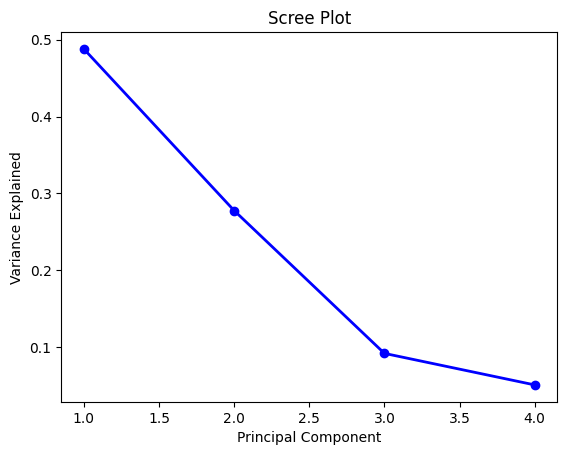

In [47]:
# scree plot

PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

It is clear here that 3 principal components should be used. The elbow of the plot is at 3 meaning that variability captured by the PC's drops off after this number of PCs.

In [48]:
# Pc data frame with just 3 PCs as specified above
pca = PCA(n_components=3)
top5_pass_style_pca = pca.fit_transform(top5_pass_style_scaled)

pc_df = pd.DataFrame(data = top5_pass_style_pca, columns=['PC1', 'PC2', 'PC3'])

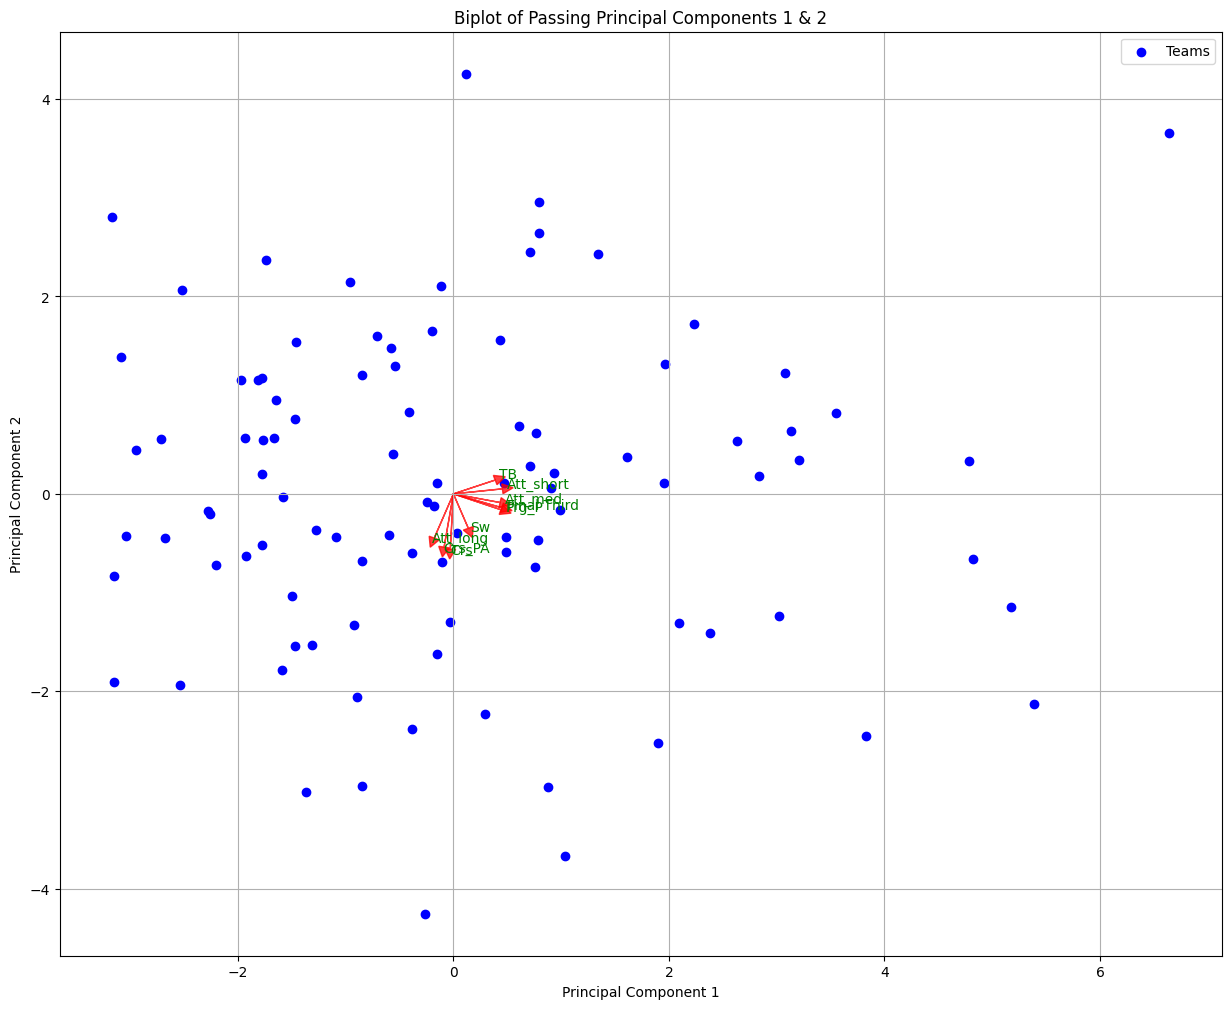

In [49]:
# plot biplot of PC1 and PC2

loadings = pca.components_[:3,:]

fig, ax = plt.subplots(figsize=(15,12))
ax.scatter(pc_df['PC1'], pc_df['PC2'], c='b', marker='o', label='Teams')

# plot loadings of variables as arrows
for i, (x, y, z) in enumerate(loadings.T):
  ax.arrow(0, 0, x, y, color='r', alpha = 0.75, head_width=0.1, head_length=0.1)
  ax.text(x * 1.1, y * 1.1, top5_pass_style.columns[i], color='g')

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')

plt.title('Biplot of Passing Principal Components 1 & 2')
plt.legend()
plt.grid()
plt.show()

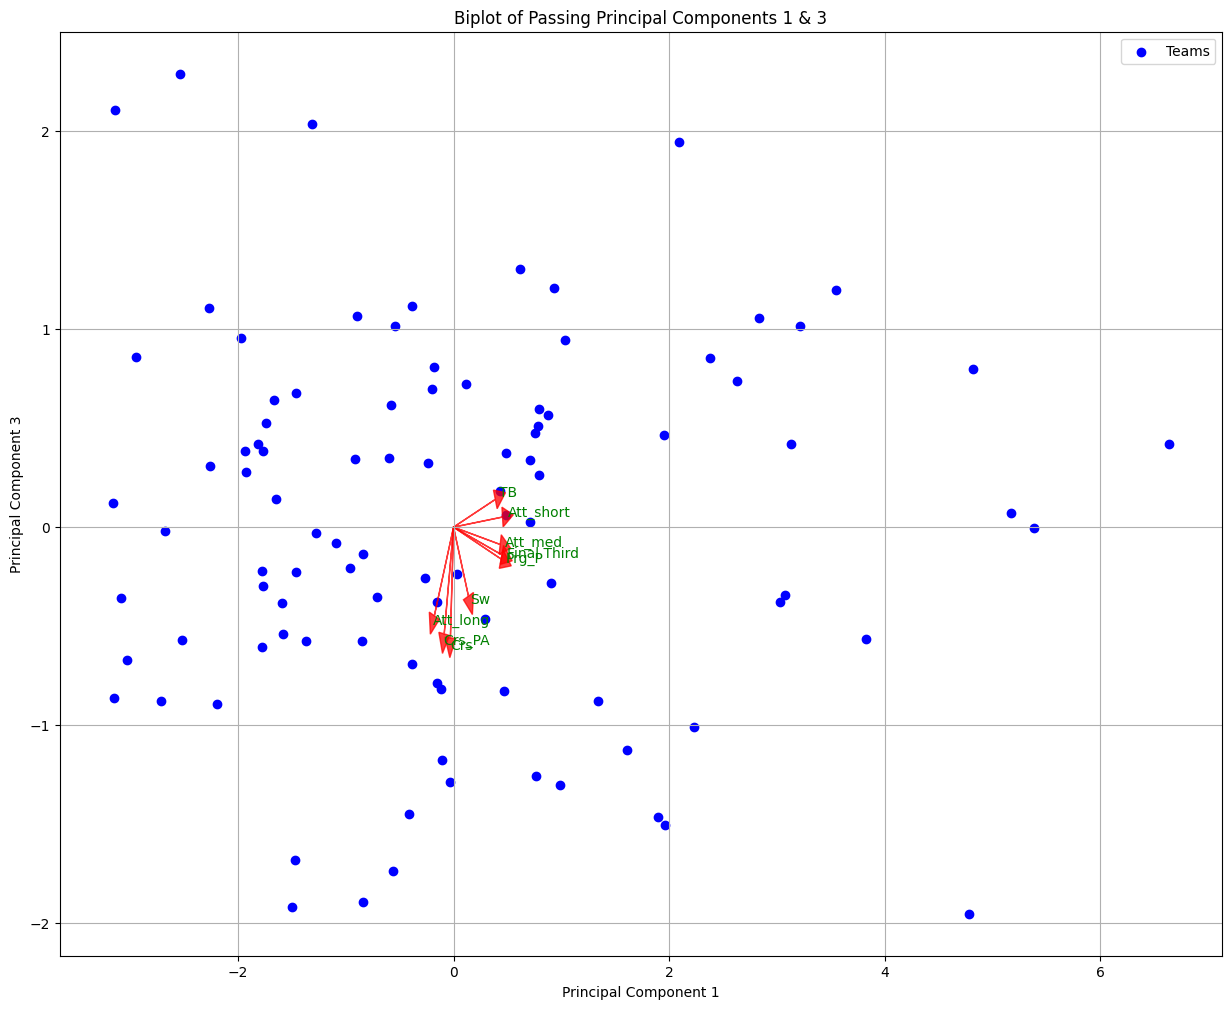

In [50]:
loadings = pca.components_[:3,:]

fig, ax = plt.subplots(figsize=(15,12))
ax.scatter(pc_df['PC1'], pc_df['PC3'], c='b', marker='o', label='Teams')

# plot loadings of variables as arrows
for i, (x, y, z) in enumerate(loadings.T):
  ax.arrow(0, 0, x, y, color='r', alpha = 0.75, head_width=0.1, head_length=0.1)
  ax.text(x * 1.1, y * 1.1, top5_pass_style.columns[i], color='g')

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 3')

plt.title('Biplot of Passing Principal Components 1 & 3')
plt.legend()
plt.grid()
plt.show()

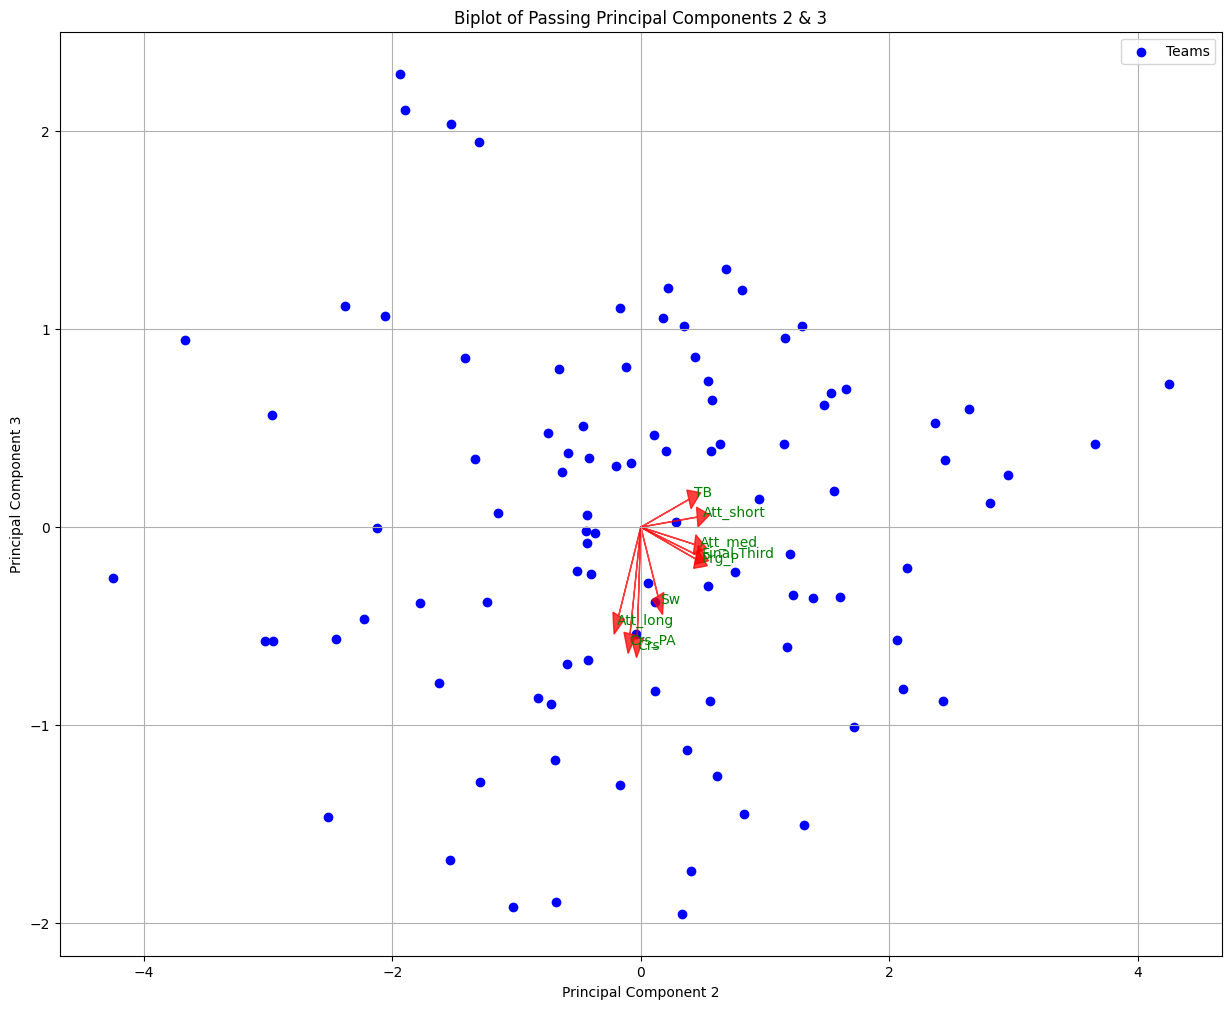

In [51]:
loadings = pca.components_[:3,:]

fig, ax = plt.subplots(figsize=(15,12))
ax.scatter(pc_df['PC2'], pc_df['PC3'], c='b', marker='o', label='Teams')

# plot loadings of variables as arrows
for i, (x, y, z) in enumerate(loadings.T):
  ax.arrow(0, 0, x, y, color='r', alpha = 0.75, head_width=0.1, head_length=0.1)
  ax.text(x * 1.1, y * 1.1, top5_pass_style.columns[i], color='g')

ax.set_xlabel('Principal Component 2')
ax.set_ylabel('Principal Component 3')

plt.title('Biplot of Passing Principal Components 2 & 3')
plt.legend()
plt.grid()
plt.show()

These biplots are extremely useful for further feature selection as it shows that no individual variables contribute very much to the three principal components. If any of the arrows reached the edges of the biplot, they would be significant in contributing to the PC in that direction, but all arrows are pretty short. The angle between the variable loadings indicates the correlation: arrows that are on top of each other indicate very highly correlated variables. In PC 1 it is clear that medium passes, progressive passes and final third passes are highly correlated. Because of this I will drop medium passes and final third passes-- it makes sense that in the context of style of play progressive passes would be the most meaningful statistic out of these 3. Per FB refererence, progressive passes include passes into the penalty area so it could indicate a style of play where teams are focused on working the ball into the box rather than crossing. Additionally, crosses and crosses into the penalty area are highly correlated. I will keep just crosses because it is more indicative of style of play while crosses into penalty area is more indicative of how good a team is at crossing. This is less relevant for this analysis. By pairing down the features even more I am trying to create principal components that explain more of the variability and that are made up of variables that contribute more to their respective principal components. This is important because when I do clustering with the PCs I can interpret which type of passing is most important for each cluster.

**Removing  redundant features and running PCA again**

In [52]:
cols_keep = ["Att_short", "Att_long", "TB", "Sw", "Crs", "Prg_P"]
top5_pass_style_2 = top5_pass_num.loc[:,cols_keep].copy()
top5_pass_style_2

# Standardize the data
scaler = StandardScaler()
top5_pass_style_scaled_2 = scaler.fit_transform(top5_pass_style_2)

In [53]:
# perform PCA

pca = PCA(n_components=4)

top5_pass_style_pca_2 = pca.fit_transform(top5_pass_style_scaled_2)

In [54]:
# The amount of variance explained by each component
explained_variance = pca.explained_variance_ratio_
explained_variance

array([0.45713879, 0.29991883, 0.11193653, 0.07281339])

In [55]:
# Cumulative variance explained by the components
cumulative_variance = np.cumsum(explained_variance)
cumulative_variance

array([0.45713879, 0.75705762, 0.86899416, 0.94180755])

As shown here, the first two PCs explain less variability in the data overall but with the third PC about 1.2% more variability is explained so I will still proceed.

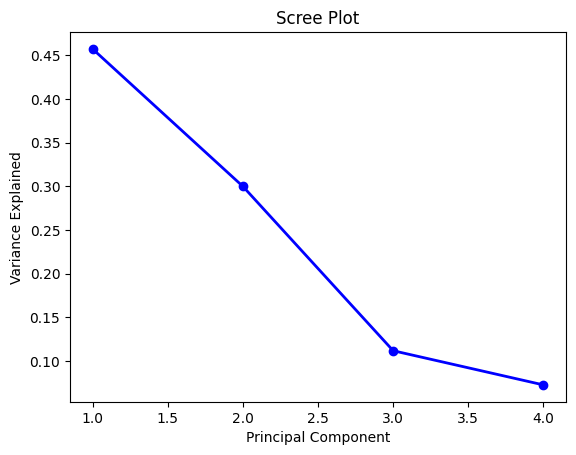

In [56]:
# scree plot

PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

This once again confirms the need to use 3 PCs for my analysis.

In [57]:
# Pc data frame with just 3 PCs as specified above
pca = PCA(n_components=3)
top5_pass_style_pca_2 = pca.fit_transform(top5_pass_style_scaled_2)

pc_df = pd.DataFrame(data = top5_pass_style_pca_2, columns=['PC1', 'PC2', 'PC3'])

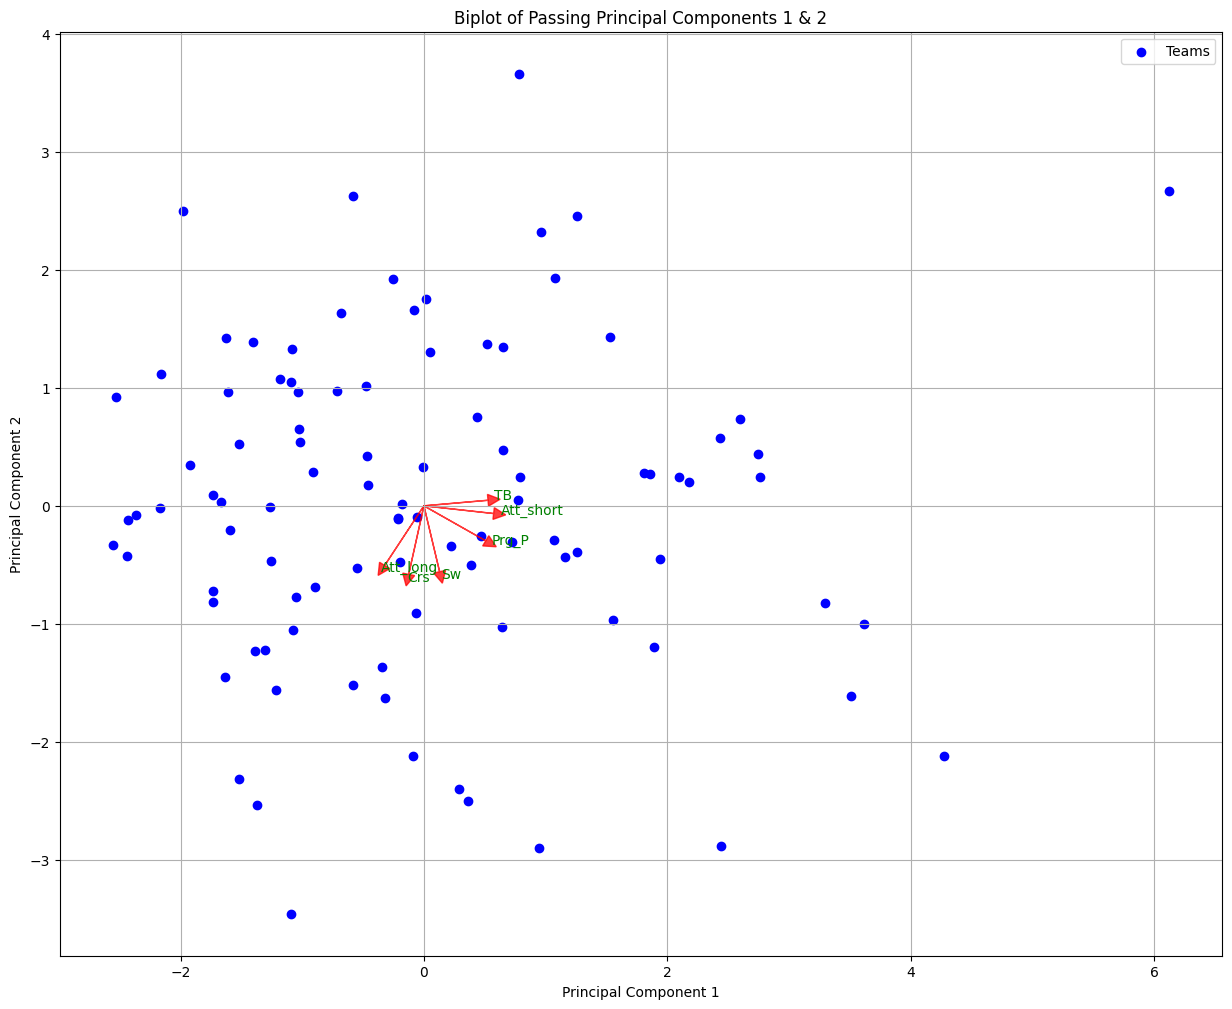

In [58]:
# plot biplot of PC1 and PC2

loadings = pca.components_[:3,:]

fig, ax = plt.subplots(figsize=(15,12))
ax.scatter(pc_df['PC1'], pc_df['PC2'], c='b', marker='o', label='Teams')

# plot loadings of variables as arrows
for i, (x, y, z) in enumerate(loadings.T):
  ax.arrow(0, 0, x, y, color='r', alpha = 0.75, head_width=0.1, head_length=0.1)
  ax.text(x * 1.1, y * 1.1, top5_pass_style_2.columns[i], color='g')

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')

plt.title('Biplot of Passing Principal Components 1 & 2')
plt.legend()
plt.grid()
plt.show()

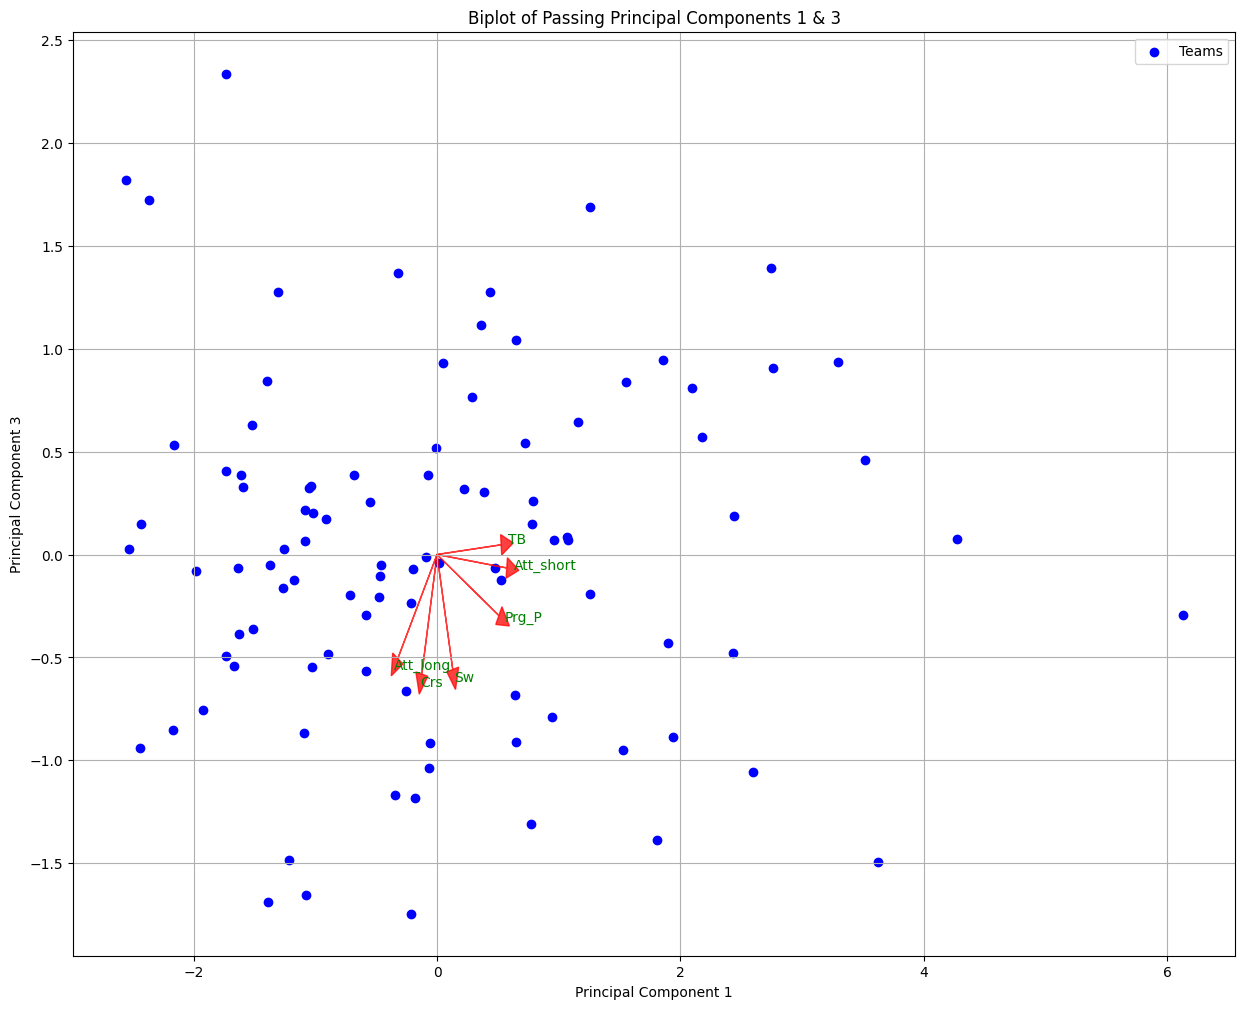

In [59]:
loadings = pca.components_[:3,:]

fig, ax = plt.subplots(figsize=(15,12))
ax.scatter(pc_df['PC1'], pc_df['PC3'], c='b', marker='o', label='Teams')

# plot loadings of variables as arrows
for i, (x, y, z) in enumerate(loadings.T):
  ax.arrow(0, 0, x, y, color='r', alpha = 0.75, head_width=0.1, head_length=0.1)
  ax.text(x * 1.1, y * 1.1, top5_pass_style_2.columns[i], color='g')

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 3')

plt.title('Biplot of Passing Principal Components 1 & 3')
plt.legend()
plt.grid()
plt.show()

With this final pruned data set about 86.9% of the variability in the data is captured in the first 3 principal components which is satisfactory for me. The 3 scree plots of the combinations of PCs show that there are now no variables extremely correlated with each other in this plane and that there are distinct differences between PC3/PC2 and PC1. Long passes, crosses, and switches of play are important for PC 3 and PC 2 while through balls, short passes, and progressive passes are important for PC 1. I will now use these PCs to create a 3D scatterplot in order to try and visualize the clusters of teams.

# **Running Kmeans with 3 PCs**

I will now run the Kmeans algorithm on this final data set with 3 PCs and visualize it use matplotlib. I'll use an elbow plot to see what the best number of clusters is.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


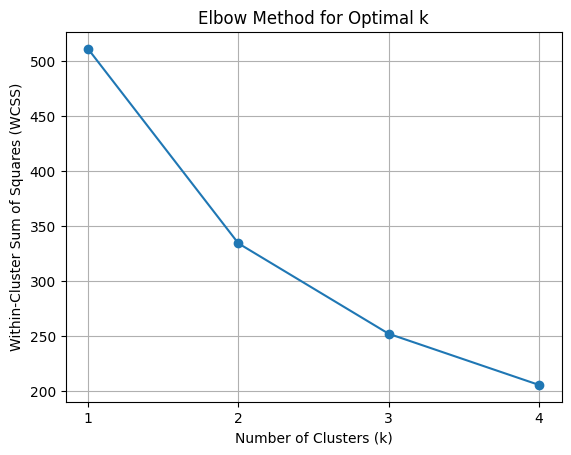

In [60]:
# within sums of squares list
wcss = []

# add wcss to the list for each amount of clusters
for k in range(1, 5):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(top5_pass_style_pca_2)
    wcss.append(kmeans.inertia_)

# Plot the WCSS for different values of k
plt.plot(range(1, 5), wcss, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Optimal k')
plt.xticks(range(1, 5))
plt.grid()
plt.show()

The WCSS drop off is less than 50 between 3 and 4 clusters meaning that the sum of the square distance between the points and the centroid of each cluster does not change very much here. I will proceed with 3 clusters.

In [61]:
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(top5_pass_style_pca_2)

# obtain cluster labels for each team
cluster_labels = kmeans.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


<ipython-input-82-0bb9f19f0d28>:15: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter1 = ax.scatter(


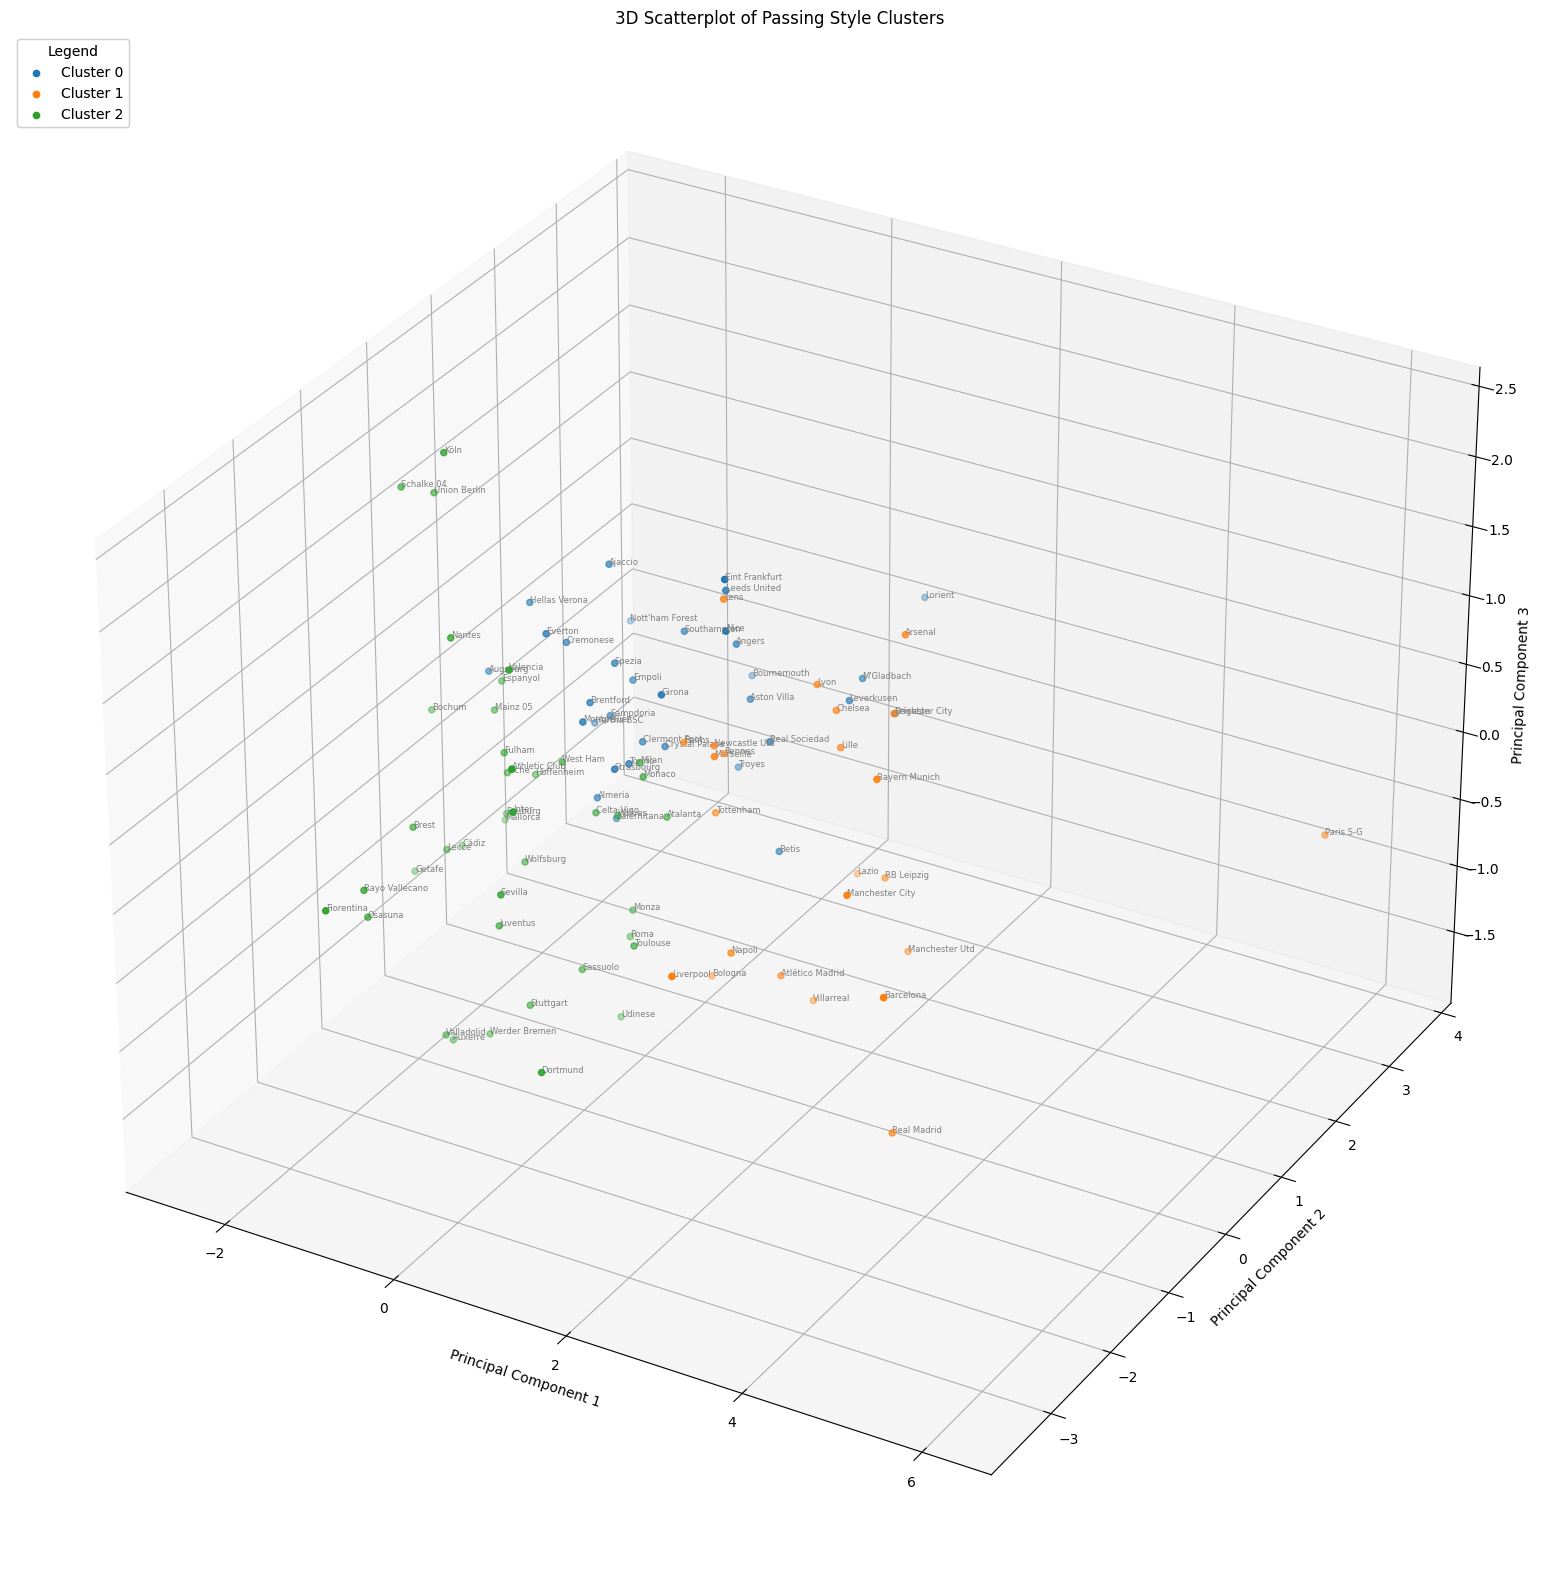

In [82]:
from mpl_toolkits.mplot3d import Axes3D

# get squad names to use as text labels
labels = top5_pass['Squad'].values

# 3D scatterplot of clusters
x = pc_df['PC1']
y = pc_df['PC2']
z = pc_df['PC3']

# plot each point colored by the respective cluster
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, projection = '3d')
for cluster_id in range(num_clusters):
    scatter1 = ax.scatter(
        top5_pass_style_pca_2[cluster_labels == cluster_id, 0],
        top5_pass_style_pca_2[cluster_labels == cluster_id, 1],
        top5_pass_style_pca_2[cluster_labels == cluster_id, 2],
        label=f'Cluster {cluster_id}',
        cmap='viridis',
    )

# print the squad names next to each point
texts = []
for i in range(len(top5_pass_style_pca_2)):
    texts.append(
        ax.text(
            top5_pass_style_pca_2[i, 0],
            top5_pass_style_pca_2[i, 1],
            top5_pass_style_pca_2[i, 2],
            labels[i],
            fontsize=6,
            color='grey',
        )
    )


legend1 = ax.legend(["Cluster 0", "Cluster 1", "Cluster 2"],
                    title="Legend", loc='upper left')
ax.add_artist(legend1)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.title('3D Scatterplot of Passing Style Clusters')
plt.show()




In [63]:
# Define a threshold for considering important variables
loading_threshold = 0.5

# Loop through principal components
for pc_id in range(3):
    # Calculate the variable loadings (importance) for the current principal component
    loadings = pca.components_[pc_id]  # Change the index to the current principal component
    sorted_loadings = np.argsort(np.abs(loadings))[::-1]  # Sort indices based on absolute values

    # Print the important variables for the current principal component
    print(f"Principal Component {pc_id + 1} - Important Variables:")
    for i in sorted_loadings:
        if np.abs(loadings[i]) >= loading_threshold:
            print(f"Variable: {top5_pass_style_2.columns[i]}, Loading: {loadings[i]:.3f}")

    print()


Principal Component 1 - Important Variables:
Variable: Att_short, Loading: 0.573
Variable: TB, Loading: 0.527
Variable: Prg_P, Loading: 0.508

Principal Component 2 - Important Variables:
Variable: Crs, Loading: -0.581
Variable: Sw, Loading: -0.559
Variable: Att_long, Loading: -0.505

Principal Component 3 - Important Variables:
Variable: Sw, Loading: -0.695
Variable: Crs, Loading: 0.662



Principal component 1 measures a team’s tendency to play shorter passes, progressive passes and through balls while principal component 2 measures a team’s tendency to play long passes, switches of play, and crosses. Principal component 3 measures a team’s tendency to switch the play and play crosses. This is useful because it does divide teams into styles of play. Those that are near each other in the PC1 direction do shorter build up play and work the ball into the box. Those that are close to each other in the PC2 and PC3 direction rely more on long balls and crosses, i.e. direct play. The location of each point represents its score on each principal component, So for example Fiorentina, Osasuna, and Vallecano are similar in play style. In another location, Lazio, Leipzig, and Manchester City are similar in play style. It is cool to see that teams from different leagues are clustered in this way. While there are not 3 distinct groups (there is overlap between the blue and green cluster) like I hypothesized, I think this is still a good graph to get a general sense of teams with similar passing styles.


**Adding cluster labels to Data Frame**

In [64]:
cluster_labels

array([0, 0, 0, 1, 0, 2, 2, 1, 0, 2, 1, 1, 0, 2, 1, 0, 0, 2, 1, 2, 2, 1,
       0, 0, 0, 2, 0, 2, 0, 2, 0, 2, 2, 2, 2, 0, 0, 0, 2, 2, 2, 2, 1, 2,
       0, 0, 1, 0, 1, 1, 0, 1, 0, 2, 2, 1, 1, 1, 2, 2, 0, 2, 2, 1, 1, 0,
       0, 2, 1, 2, 1, 1, 0, 1, 1, 2, 0, 0, 2, 2, 2, 0, 0, 0, 2, 0, 1, 2,
       0, 2, 2, 2, 2, 1, 2, 2, 2, 2], dtype=int32)

In [65]:
for row in top5_pass.iterrows():
  top5_pass['Cluster'] = cluster_labels

In [66]:
top5_pass

,Rank,Squad,Competition,Num Players,Games,Cmp_total,Att_total,Cmp%_total,Tot_Dist,Prg_Dist,Cmp_short,Att_short,Cmp%_short,Cmp_med,Att_med,Cmp%_med,Cmp_long,Att_long,Cmp%_long,Assists,x_AG,x_A,A-x_AG,K_P,Final Third,PPa,Crs_PA,Prg_P,Live,Dead,FK,TB,Sw,Crs,TI,CK,In,Out,Str,Cmp,Off,Blocks,Cluster
0,1,Ajaccio,fr Ligue 1,36,38.0,295.157895,402.263158,73.4,5433.342105,2147.000000,124.763158,152.105263,82.0,120.473684,150.026316,80.3,38.105263,76.026316,50.1,0.315789,0.597368,0.615789,-0.281579,6.157895,25.105263,4.947368,1.868421,30.763158,351.789474,48.815789,14.789474,1.026316,1.500000,16.605263,20.921053,3.315789,1.105263,1.710526,0.000000,295.157895,1.657895,9.184211,0
1,2,Almería,es La Liga,29,38.0,319.763158,417.236842,76.6,5933.552632,2349.368421,137.684211,157.973684,87.2,133.789474,158.473684,84.4,39.789474,76.605263,51.9,0.868421,0.855263,0.739474,0.013158,8.315789,22.263158,5.736842,2.131579,28.684211,364.868421,50.184211,14.526316,1.289474,3.473684,15.921053,19.736842,3.868421,1.526316,1.552632,0.026316,319.763158,2.184211,8.105263,0
2,3,Angers,fr Ligue 1,33,38.0,371.131579,459.552632,80.8,6650.236842,2335.473684,156.157895,179.210526,87.1,164.447368,189.684211,86.7,37.763158,66.736842,56.6,0.473684,0.736842,0.726316,-0.263158,7.263158,29.578947,5.631579,1.710526,36.657895,412.868421,45.447368,12.710526,1.052632,2.421053,15.368421,18.552632,4.315789,2.578947,1.105263,0.000000,371.131579,1.236842,7.736842,0
3,4,Arsenal,eng Premier League,26,38.0,481.078947,578.131579,83.2,8163.315789,2648.289474,224.789474,249.421053,90.1,205.921053,232.131579,88.7,38.263158,67.052632,57.1,1.684211,1.415789,1.231579,0.268421,11.657895,43.078947,12.078947,1.631579,53.921053,534.026316,42.631579,13.578947,2.263158,2.552632,17.736842,16.184211,5.868421,4.052632,0.210526,0.078947,481.078947,1.473684,9.973684,1
4,5,Aston Villa,eng Premier League,26,38.0,362.684211,457.789474,79.2,6423.263158,2304.763158,160.763158,182.763158,88.0,157.394737,182.526316,86.2,35.394737,67.868421,52.2,0.921053,1.021053,0.831579,-0.100000,8.368421,25.368421,7.052632,2.105263,32.684211,409.052632,47.210526,15.763158,1.421053,2.657895,14.763158,18.000000,4.263158,2.552632,0.500000,0.105263,362.684211,1.526316,8.552632,0
5,6,Atalanta,it Serie A,27,38.0,406.894737,513.342105,79.3,7051.868421,2565.578947,190.657895,216.684211,88.0,164.052632,193.421053,84.8,40.131579,73.105263,54.9,1.105263,1.123684,1.073684,-0.018421,10.657895,31.157895,10.131579,2.342105,43.078947,461.500000,50.315789,11.368421,0.921053,4.052632,17.157895,23.500000,5.105263,2.552632,1.763158,0.000000,406.894737,1.526316,9.447368,2
6,7,Athletic Club,es La Liga,26,38.0,380.000000,490.263158,77.5,6884.736842,2527.289474,169.763158,195.552632,86.8,158.684211,191.105263,83.0,43.000000,75.736842,56.8,0.868421,1.023684,0.939474,-0.155263,10.868421,36.447368,8.973684,2.815789,47.789474,436.684211,51.052632,13.210526,1.157895,5.026316,24.157895,21.973684,6.763158,1.736842,3.236842,0.026316,380.000000,2.526316,10.157895,2
7,8,Atlético Madrid,es La Liga,27,38.0,442.473684,539.157895,82.1,7305.973684,2679.973684,226.736842,248.210526,91.3,158.631579,185.210526,85.6,40.763158,72.763158,56.0,1.342105,1.276316,1.052632,0.065789,11.000000,31.578947,8.815789,1.789474,41.342105,490.263158,46.815789,12.894737,2.184211,5.078947,16.447368,18.473684,4.815789,2.552632,1.210526,0.000000,442.473684,2.078947,9.078947,1
8,9,Augsburg,de Bundesliga,34,34.0,247.705882,374.764706,66.1,4982.588235,2212.205882,91.294118,118.588235,77.0,113.058824,148.529412,76.1,36.852941,82.911765,44.4,0.852941,0.714706,0.723529,0.138235,7.058824,19.470588,5.617647,1.294118,24.911765,321.029412,52.029412,12.588235,0.882353,2.147059,16.117647,21.911765,4.882353,2.294118,2.382353,0.029412,247.705882,1.705882,9.764706,0
9,10,Auxerre,fr Ligue 1,33,38.0,325.947368,420.763158,77.5,6330.842105,2393.868421,127.289474,150.236842,84.7,138.473684,162.552632,85.2,48.368421,85.184211,56.8,0.447368,0.715789,0.673684,-0.268421,7.921053,26.842105,6.394737,2.157895,

Now the original data frame has a column containing the cluster label for each team. This is useful for further analysis because the data can now be sliced by cluster to look at only teams within each group.

# **3D Scatterplot Takeaways**

While I was successfully able to cluster teams based on a few features, the use of principal components combined with clustering does not lend itself well to interpretability. I know that teams within each cluster that are close to each other have similar scores based on the principal components, and I know the most important variables for those principal components, but nailing down the exact way of playing that each cluster represents is not entirely possible with my analysis. However, what I have done is useful for seeing which teams are at their very core similar in terms of how they pass. This has applications in scouting and opponent analysis. When searching for new signings that may fit a team's play style, one could look at this 3D scatter plot or search in the data frame for teams within the cluster that their team belongs to. Say West Ham were looking to further bolster their midfield after losing Declan Rice. They could look at this graph and identify Hoffenheim or Athletic Club as teams with potentially suitable midfielders based on passing style. Of course this would only be a very small part of the scouting process but it would allow the scouting staff to gain insight into play style compatability. There is so much that goes into a transfer being successful so any unique information such as this could be a very important piece in the puzzle. Additionally, this could be used to look at opponents, especially those in European competitions such as the Europa League or Champions League. If hypothetically Rennes had to play Roma in the Europa League, they could look at this plot and notice that Roma is very similar to Toulouse in terms of passing style, who they play domestically and far more frequently.

**Continued Analysis**

Now I will pull another set of data from FB ref. I'm taking the overall statistics and will merge the two data frames in order to have some more statistics such as league rank, wins, points per match, goals scored, and goals conceded. This way I can see which cluster has the highest average league rank, best goal scoring average, etc.

In [67]:
top5_overall = pd.read_html('https://fbref.com/en/comps/Big5/2022-2023/Big-5-European-Leagues-Stats')

for idx,table in enumerate(top5_overall):
 print('***************************')
 print(idx)
 print(table)
t5_ovr = top5_overall[0]
t5_ovr


***************************
0
    Rk            Squad  Country  LgRk  MP   W   D   L  GF  GA  GD  Pts  \
0    1           Napoli   it ITA     1  38  28   6   4  77  28  49   90   
1    2  Manchester City  eng ENG     1  38  28   5   5  94  33  61   89   
2    3        Barcelona   es ESP     1  38  28   4   6  70  20  50   88   
3    4        Paris S-G   fr FRA     1  38  27   4   7  89  40  49   85   
4    5          Arsenal  eng ENG     2  38  26   6   6  88  43  45   84   
5    6             Lens   fr FRA     2  38  25   9   4  68  29  39   84   
6    7    Bayern Munich   de GER     1  34  21   8   5  92  38  54   71   
7    8         Dortmund   de GER     2  34  22   5   7  83  44  39   71   
8    9      Real Madrid   es ESP     2  38  24   6   8  75  36  39   78   
9   10  Atlético Madrid   es ESP     3  38  23   8   7  70  33  37   77   
10  11   Manchester Utd  eng ENG     3  38  23   6   9  58  43  15   75   
11  12            Lazio   it ITA     2  38  22   8   8  60  30  30   7

,Rk,Squad,Country,LgRk,MP,W,D,L,GF,GA,GD,Pts,Pts/MP,xG,xGA,xGD,xGD/90,Attendance,Top Team Scorer,Goalkeeper
0,1,Napoli,it ITA,1,38,28,6,4,77,28,49,90,2.37,64.7,31.8,33.0,0.87,46173,Victor Osimhen - 26,Alex Meret
1,2,Manchester City,eng ENG,1,38,28,5,5,94,33,61,89,2.34,78.7,32.1,46.6,1.23,53249,Erling Haaland - 36,Ederson
2,3,Barcelona,es ESP,1,38,28,4,6,70,20,50,88,2.32,75.5,33.2,42.3,1.11,83498,Robert Lewandowski - 23,Marc-André ter Stegen
3,4,Paris S-G,fr FRA,1,38,27,4,7,89,40,49,85,2.24,78.2,48.3,29.9,0.79,46334,Kylian Mbappé - 29,Gianluigi Donnarumma
4,5,Arsenal,eng ENG,2,38,26,6,6,88,43,45,84,2.21,71.9,42.0,29.9,0.79,60191,"Martin Ødegaard, Gabriel Martinelli - 15",Aaron Ramsdale
5,6,Lens,fr FRA,2,38,25,9,4,68,29,39,84,2.21,66.9,43.3,23.6,0.62,37652,Loïs Openda - 21,Brice Samba
6,7,Bayern Munich,de GER,1,34,21,8,5,92,38,54,71,2.09,75.0,37.1,37.8,1.11,75000,Serge Gnabry - 14,Yann Sommer
7,8,Dortmund,de GER,2,34,22,5,7,83,44,39,71,2.09,71.1,43.2,27.9,0.82,81228,"Julian Brandt, Donyell Malen... - 9",Gregor Kobel
8,9,Real Madrid,es ESP,2,38,24,6,8,75,36,39,78,2.05,75.5,38.9,36.6,0.96,56649,Karim Benzema - 19,Thibaut Courtois
9,10,Atlético Madrid,es ESP,3,38,23,8,7,70,33,37,77,2.03,62.3,41.3,20.9,0.55,55800,Antoine Griezmann - 15,Jan Oblak


In [68]:
# make sure stats are on per game basis

t5_ovr = t5_ovr.loc[:,['LgRk', 'MP', 'Squad', 'W', 'D', 'L', 'GF', 'GA', 'Pts/MP', 'xG', 'xGA']]

t5_ovr[['GF', 'GA', 'xG', 'xGA']] = t5_ovr[['GF', 'GA', 'xG', 'xGA']].div(t5_ovr.MP, axis=0).round(2)

In [69]:
# merge two data frames

t5 = t5_ovr.merge(top5_pass, on = "Squad")

In [70]:
# don't need Matches Played (MP)

t5.drop(['MP'], axis=1, inplace = True)

In [71]:
# Create data frame for each cluster so that I can compute average league rank

cluster_0 = t5.loc[t5['Cluster'] == 0]
cluster_1 = t5.loc[t5['Cluster'] == 1]
cluster_2 = t5.loc[t5['Cluster'] == 2]

In [72]:
cluster_0['LgRk'].mean()


13.606060606060606

In [73]:
cluster_1['LgRk'].mean()

4.208333333333333

In [74]:
cluster_2['LgRk'].mean()

11.24390243902439

**Average League Rank of Each Cluster (Rounded to Whole Number)**

Cluster 0: 14

Cluster 1: 4

Cluster 2: 11

Cluster 1 clearly contains the best teams while cluster 0 and 2 contain similarly ranked teams, with cluster 0 containing slightly worse clubs on average.

# **Analysis of Cluster Style**

I will use some histograms to see which statistics stand out in each cluster, comparing these to the important variables for each principal component.

[Text(0.5, 1.0, 'Histogram of Long Passes Per 90')]

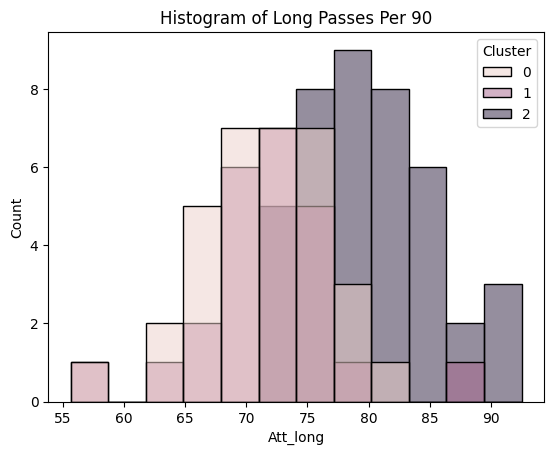

In [84]:
sns.histplot(data=t5, x="Att_long", hue="Cluster").set(title='Distribution of Teams Long Passes Per 90')

[Text(0.5, 1.0, 'Distribution of Teams Crosses Per 90')]

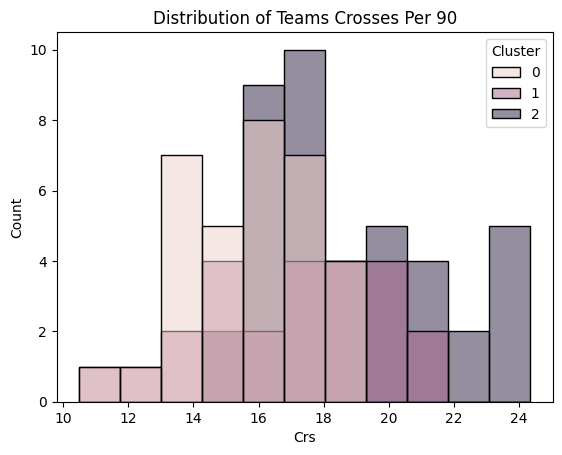

In [92]:
sns.histplot(data=t5, x="Crs", hue="Cluster").set(title='Distribution of Teams Crosses Per 90')

[Text(0.5, 1.0, 'Distribution of Teams Switches of Play Per 90')]

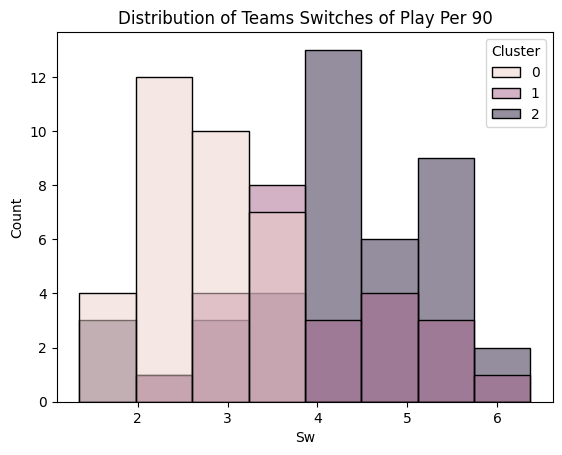

In [91]:
sns.histplot(data=t5, x="Sw", hue="Cluster").set(title='Distribution of Teams Switches of Play Per 90')

[Text(0.5, 1.0, 'Histogram of Through Balls Per 90')]

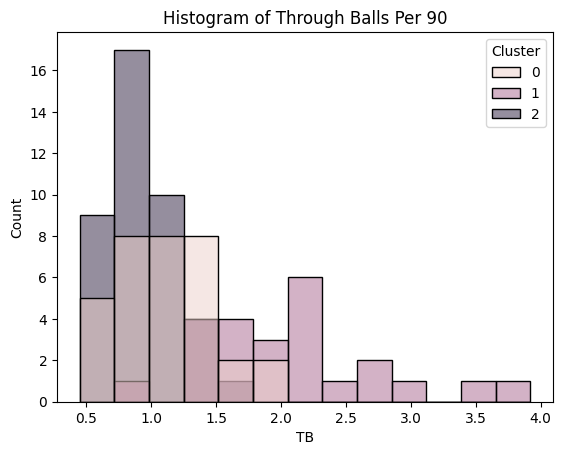

In [85]:
sns.histplot(data=t5, x="TB", hue="Cluster").set(title='Distribution of Teams Through Balls Per 90')

[Text(0.5, 1.0, 'Histogram of Progressive Passes Per 90')]

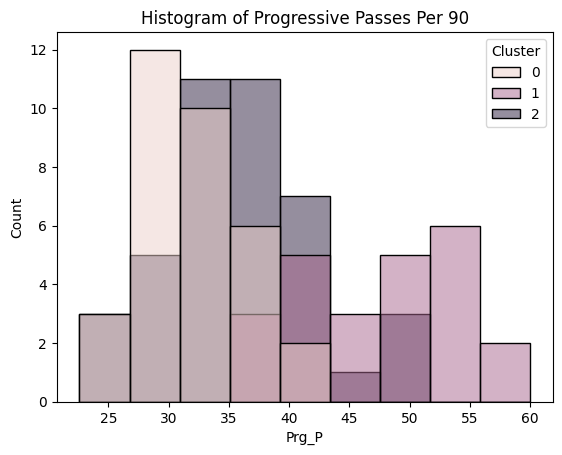

In [86]:
sns.histplot(data=t5, x="Prg_P", hue="Cluster").set(title='Distribution of Teams Progressive Passes Per 90')

[Text(0.5, 1.0, 'Histogram of Short Passes Per 90')]

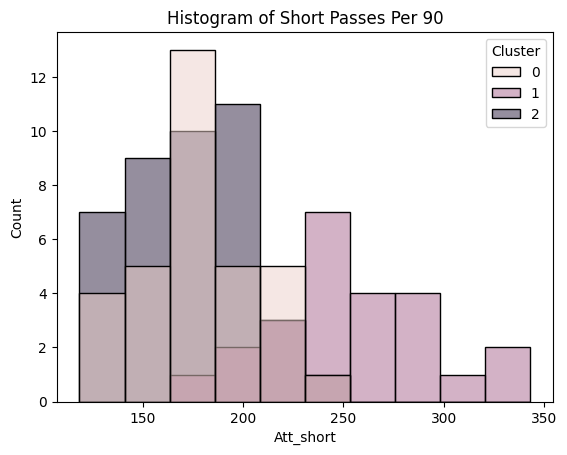

In [87]:
sns.histplot(data=t5, x="Att_short", hue="Cluster").set(title='Distribution of Teams Short Passes Per 90')

[Text(0.5, 1.0, 'Histogram of Medium Passes Per 90')]

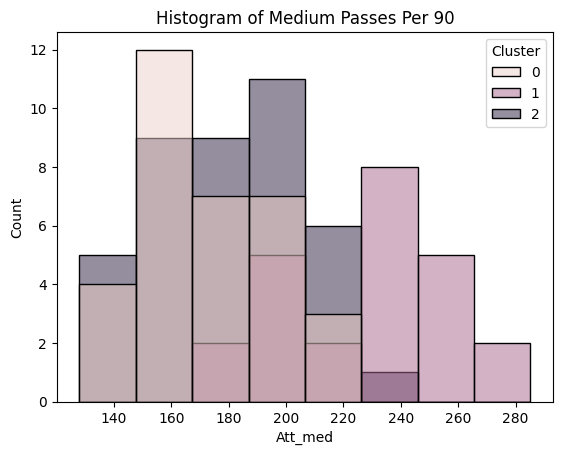

In [88]:
sns.histplot(data=t5, x="Att_med", hue="Cluster").set(title='Distribution of Teams Medium Passes Per 90')

[Text(0.5, 1.0, 'Histogram of Points per Match Played')]

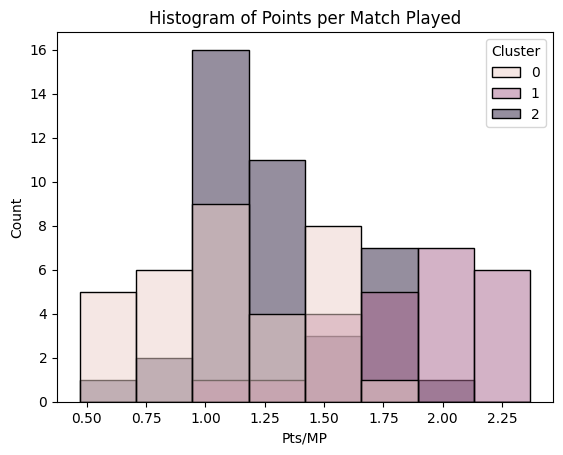

In [89]:
sns.histplot(data=t5, x="Pts/MP", hue="Cluster").set(title='Distribution of Teams Points per Match Played')

# **Takeaways From Cluster Style Analysis**


These histograms line up with the variable importance in each cluster/principal component. Cluster 1 has the best performing teams and they tend to attempt lots of short passes, medium passes, through balls, and progressive passes. The only stylistic information we can get about cluster 2 is that these teams tend to play more long balls and crosses than teams in the other clusters. Cluster 0 appears to be the weakest teams in terms of league rank and the amount of passes they attempt in all categories.